# Functions

In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import wandb
import time
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import pandas as pd
from IPython.display import IFrame, display
from IPython.display import HTML
import pickle
import numpy as np

class HelperClass:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.wandb_run = None

    def train(self, train_loader,test_loader, num_epochs):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            start_traintime = time.time()
            self.model.train()
            for i, (data) in enumerate(train_loader, 0):
                inputs, labels = data
                
                #for k in range(len(inputs)):
                 #   plt.imshow(inputs[k].permute(1, 2, 0))
                  #  plt.show()
                
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / (i+1)
            endtime_train = time.time() - start_traintime
            test_accuracy, train_accuracy, train_loss, test_loss = self.evaluate(test_loader=test_loader, train_loader=train_loader, train_loss=train_loss, endtime_train=endtime_train)
            print(f"Epoch {epoch+1}, Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
        print("Finished Training")
        wandb.finish()
        return self.model


    def evaluate(self, test_loader, train_loader, train_loss, endtime_train):
        # Evaluate the model on test_loader
        self.model.to(self.device)
        self.model.eval()
        correct = 0
        total = 0
        batches = 0
        test_loss = 0
        starttime_test = time.time()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                test_loss += self.criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                batches += 1
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_loss = test_loss / batches

        # Evaluate the model on the train_loader
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        endtime_test = time.time() - starttime_test
        wandb.log(
            {
                "test_accuracy": test_accuracy,
                "train_accuracy": train_accuracy,
                "train_loss": train_loss,
                "test_loss": test_loss,
                "time_train": endtime_train,
                "time_test": endtime_test,

            }    
        )
        return test_accuracy, train_accuracy, train_loss, test_loss

def prepare_data(batch_size):
    
    transform = transforms.Compose(
    [transforms.ToTensor()
        , transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784), inplace=True)
    ])    
    training_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transform
    )

    test_data = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=transform
    )
    
    
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
    return train_dataloader, test_loader

def wandb_login(dict, name = None):
    
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="del-MC1",
        name = name,
        # track hyperparameters and run metadata
        config=dict
        , reinit=True
    )
    
def get_run_hist(run_ids, columns, column_names, title):
    api = wandb.Api()
    
    
    size = len(columns)
    
    if size > 2:
        if size%2 == 0:
            rows = int(size/2)
        else:
            rows = int(size/2 + 1)
        
        fig, axs = plt.subplots(rows, 2, figsize=(15, 10))
        fig.suptitle(title)
        for run_id in run_ids:
            run = api.run(path=f'del-MC1/{run_id}')
            history = run.history()
            
            for i, column in enumerate(columns):
                axs[int(i/2), i%2].plot(history[column], label=run.name)
        
        for i, column_name in enumerate(column_names):
            row = int(i/2)
            column = i%2
            axs[row, column].set_title(column_name)
            axs[row, column].legend()
            axs[row, column].grid()
            axs[row, column].set_xlabel('Epoch')
            if "Time" in column_name:
                axs[row, column].set_ylabel('sec')
            elif "Accuracy" in column_name:
                axs[row, column].set_ylabel('%')
            elif "Loss" in column_name:
                axs[row, column].set_ylabel('Loss')
            
    elif size == 2:
        fig, axs = plt.subplots(2, 1, figsize=(15, 5))
        fig.suptitle(title)
        for run_id in run_ids:
            run = api.run(path=f'del-MC1/{run_id}')
            history = run.history()
            
            for i, column in enumerate(columns):
                axs[i].plot(history[column], label=run.name)
        
        for i, column_name in enumerate(column_names):
            
            axs[i].set_title(column_name)
            axs[i].legend()
            axs[i].grid()
            axs[i].set_xlabel('Epoch')
            if "Time" in column_name:
                axs[i].set_ylabel('sec')
            elif "Accuracy" in column_name:
                axs[i].set_ylabel('%')
            elif "Loss" in column_name:
                axs[i].set_ylabel('Loss')
    plt.tight_layout()            
    
    plt.show()

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [2]:
wandb.login(key="1a0a3fe01a5c7157e1e981598f891577d07f1a83")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: denis-schatzmann. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\denis\.netrc


True

In [3]:
# Wenn alle Modelle neu trainiert werden sollen, dann auf True setzen
run_models = False

# Einführung
## Auswahl der Aufgabe
Ich möchte mit Bildern arbeiten. Ich möchte das Objekt welches auf dem Bild dargestellt ist, klassifizieren können. Was ich nicht möchte, ist die Segementierung des Bildes. Dazu benötige ich aber einen sauberen Datensatz.

## Datensatz
Der Datensatz CIFAR-10 erfüllt alle benötigten Eigenschaften. Der Datensatz besteht aus 60'000 32x32 Farbbildern in 10 Klassen, mit 6000 Bildern pro Klasse. Es gibt 50'000 Trainingsbilder und 10'000 Testbilder. Pro Bild ist jeweils nur ein Objekt abgebildet. Die Klassen sind ausbalanciert.

# Load Dataset

In [4]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified


In [5]:
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified


# EDA
Zuerst schaue ich mir den Datensatz etwas genauer an.

In [6]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Es gibt folgende zehn Labels:

In [7]:
label_names = unpickle("data/cifar-10-batches-py/batches.meta")[b'label_names']
label_names = [x.decode('utf-8') for x in label_names]
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Da ich den Datensatz von torchvision verwende, ist das Dataset bereits als effektive Dataset-Klasse implementiert. Dadurch kann ich sie direkt zu einem Dataloader hinzufügen.

In [8]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [9]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


Die Daten sind in einem 4D-Tensor gespeichert. Die Dimensionen sind wie folgt:
- 50'000 Trainingsbilder
- 32x32 Pixel pro Bild
- 3 Farbkanäle pro Pixel (RGB)

In [10]:
# Get all Data from CIFAR-10
data_train = training_data.data
labels_train = training_data.targets
print(training_data.data.shape)

(50000, 32, 32, 3)


In [11]:
index = np.where(np.array(labels_train) == 0)[0]
class_data = data_train[index]
class_data.shape

(5000, 32, 32, 3)

Ich schaue mir 100 Beispielbilder an. 10 pro Klasse.
Die Bilder sehen sehr gut aus. Ich als Person kann die Objekte gut erkennen. Bei einigen Bildern stelle ich mir aber die Frage ob ein Modell diese erkenen kann. Beispielsweise das fünfte Vogelbild zeigt einen Strauss. Jedoch ist nur der Hals mit Kopf zu sehen. 

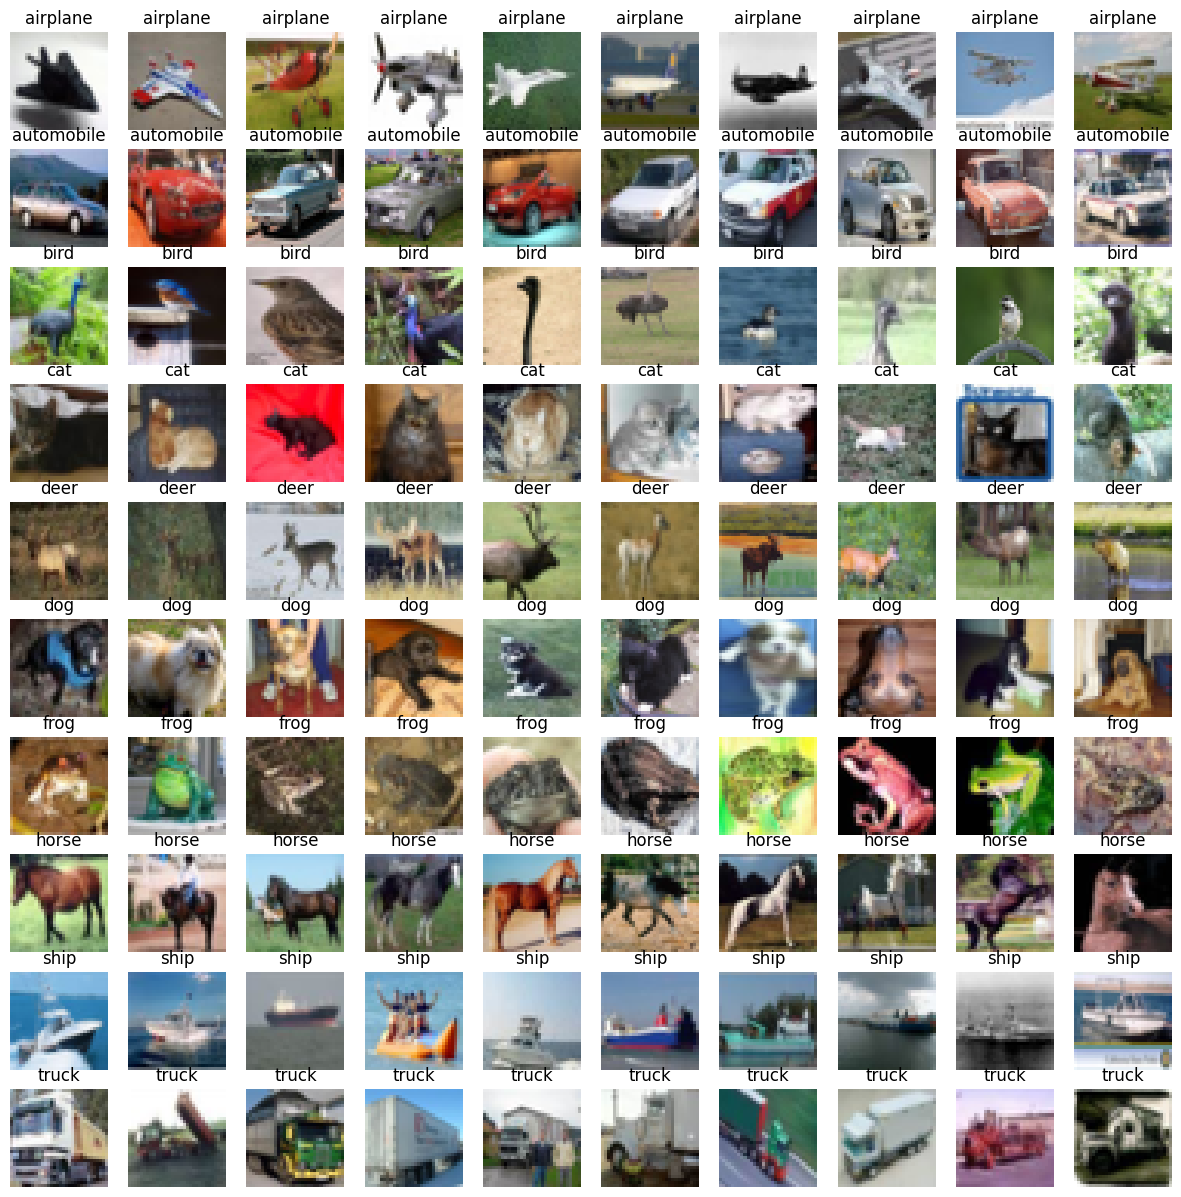

In [12]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))
for i in range(10):
    index = np.where(np.array(labels_train) == i)[0]
    class_data = data_train[index]
    for j in range(10):
        img = class_data[j].squeeze()
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis('off')
        axs[i, j].set_title(label_names[i])
plt.show()

### Verteilung der Klassen
Die einzelnen Klassen sind im Trainings- sowie im Testdatensatz exakt gleichmässig verteilt.

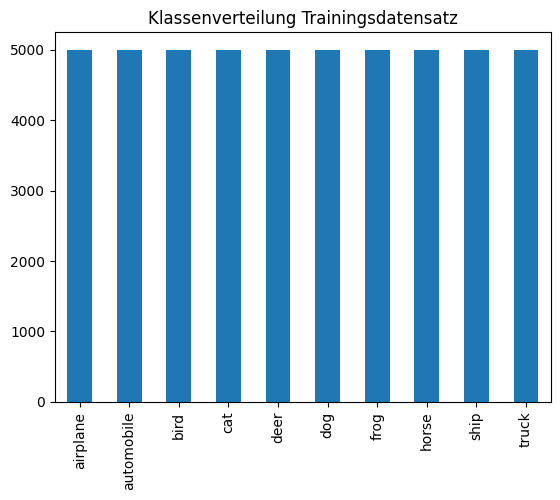

In [13]:
label_counts = pd.Series(labels_train).value_counts()
label_counts = label_counts.sort_index()
label_counts.index = label_names
label_counts.plot(kind='bar', title='Klassenverteilung Trainingsdatensatz')
plt.show()

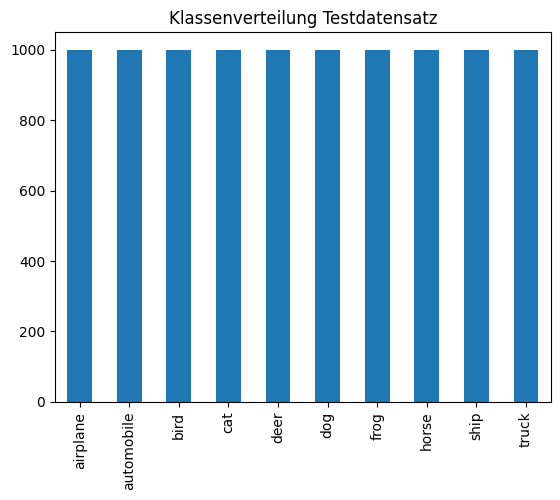

In [14]:
labels_test = test_data.targets
label_counts = pd.Series(labels_test).value_counts()
label_counts = label_counts.sort_index()
label_counts.index = label_names
label_counts.plot(kind='bar', title='Klassenverteilung Testdatensatz')
plt.show()

## Preprocessing
Die Bilder sind in RGB mit Werten pro Kanal von 0 bis 255.

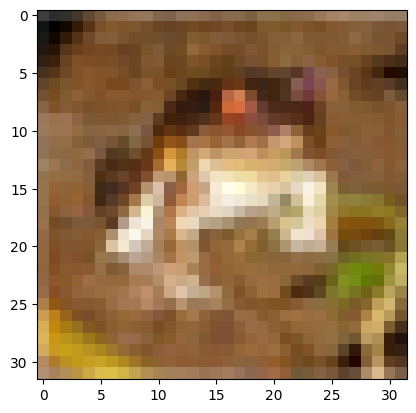

In [15]:
plt.imshow(training_data.data[0])
plt.show()

Die Bilder sehen in den Unterschiedlichen Kanälen so aus:

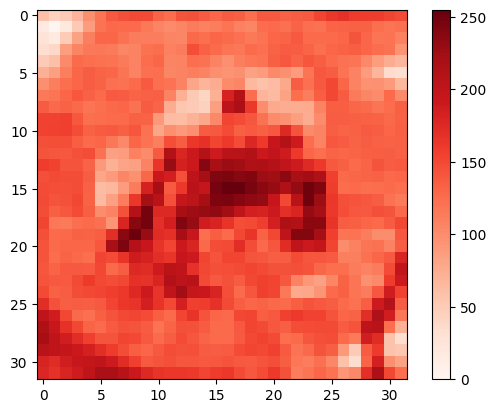

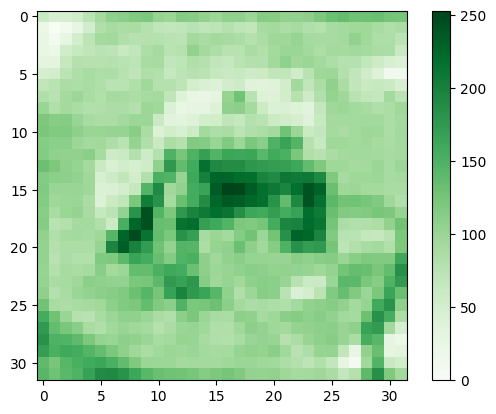

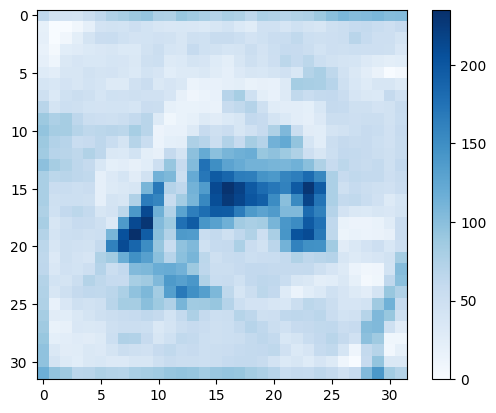

In [16]:
img = training_data.data[0]
img_r = img[:,:,0]
img_g = img[:,:,1]
img_b = img[:,:,2]
plt.imshow(img_r, cmap="Reds")
plt.colorbar()
plt.show()
plt.imshow(img_g, cmap="Greens")
plt.colorbar()
plt.show()
plt.imshow(img_b, cmap="Blues")
plt.colorbar()
plt.show()

In [17]:
training_data.data = training_data.data / 255

In [18]:
test_data.data = test_data.data / 255

Da sich nur der Wertebereich und nicht das Verhältnis der Farbwerte geändert hat, hat sich an den Bildern nichts geändert.

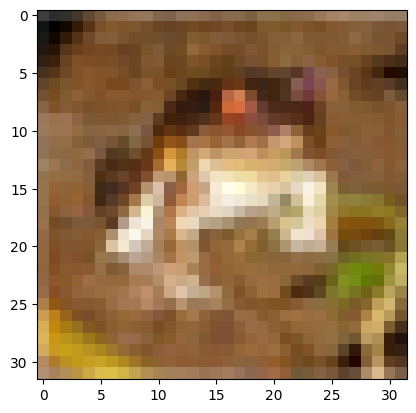

In [19]:
plt.imshow(training_data.data[0])
plt.show()

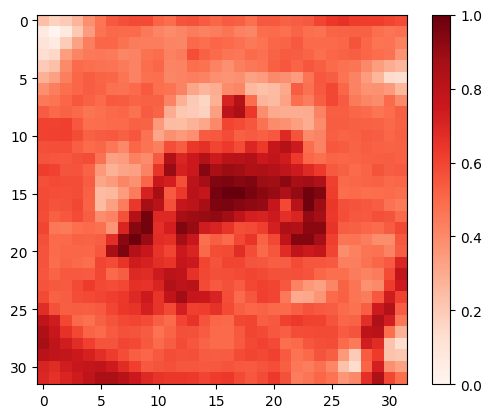

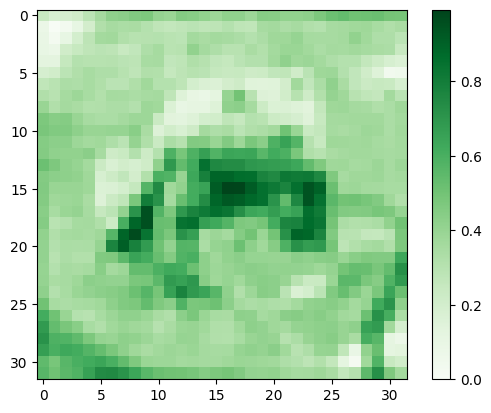

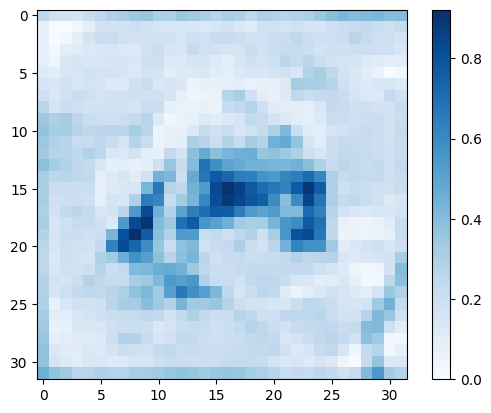

In [20]:
img = training_data.data[0]
img_r = img[:,:,0]
img_g = img[:,:,1]
img_b = img[:,:,2]
plt.imshow(img_r, cmap="Reds")
plt.colorbar()
plt.show()
plt.imshow(img_g, cmap="Greens")
plt.colorbar()
plt.show()
plt.imshow(img_b, cmap="Blues")
plt.colorbar()
plt.show()

## Analyse Verteilung der Farbwerte
Als weitere Analyse habe ich die Verteilung der Farbwerte angeschaut.

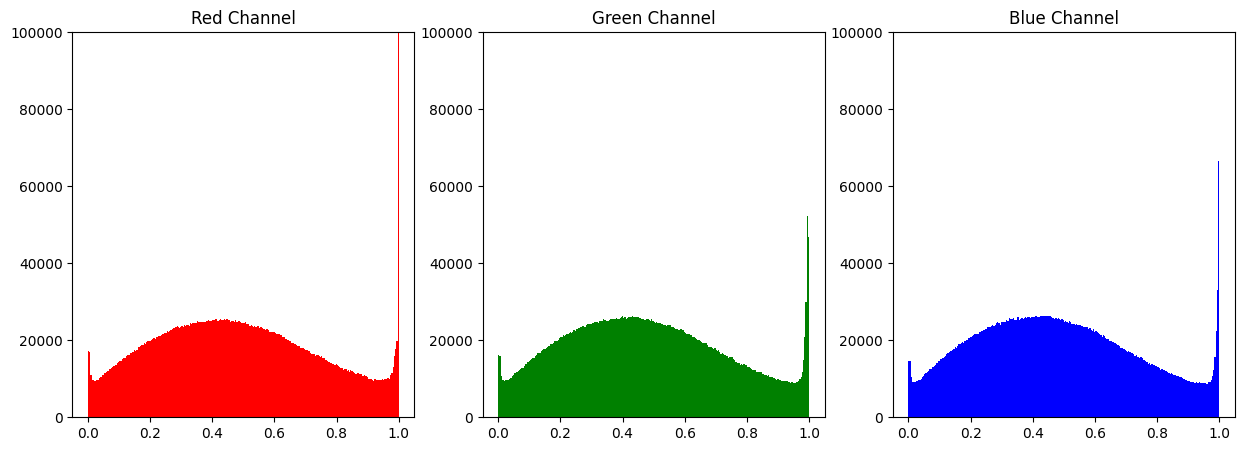

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axs[i].set_ylim(0, 100000)

axs[0].hist(training_data.data[:,:,0].flatten(), bins=256, color="red")
axs[0].set_title("Red Channel")
axs[1].hist(training_data.data[:,:,1].flatten(), bins=256, color="green")
axs[1].set_title("Green Channel")
axs[2].hist(training_data.data[:,:,2].flatten(), bins=256, color="blue")
axs[2].set_title("Blue Channel")

plt.show()

Da die Verteilung der Farbwerte gleichmäßig ist, kann ich auf das Standardisieren der Farbwerte verzichten. 
Es hat viele sehr hohe Werte. Das liegt daran, das es viele Bilder mit weissen Flächen gibt.

Ich möchte nun den Mean und die Standardabweichung der Farbwerte berechnen.

In [22]:
mean = np.mean(training_data.data, axis=(0,1,2))
std = np.std(training_data.data, axis=(0,1,2))
print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: [0.49139968 0.48215841 0.44653091]
Std: [0.24703223 0.24348513 0.26158784]


Files already downloaded and verified


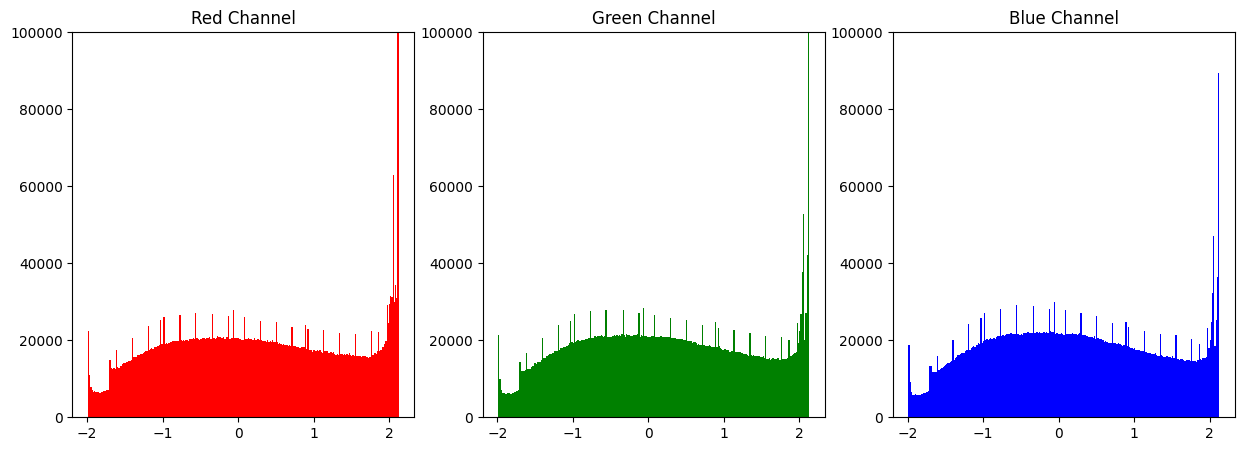

In [23]:
transform = transforms.Compose(
[transforms.ToTensor()
, transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
 ])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(training_data, batch_size=50000)

data, labels = next(iter(dataloader))
    


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].set_ylim(0, 100000)


axs[0].hist(data[:,:,0].flatten(), bins=255, color="red")
axs[0].set_title("Red Channel")
axs[1].hist(data[:,:,1].flatten(), bins=255, color="green")
axs[1].set_title("Green Channel")
axs[2].hist(data[:,:,2].flatten(), bins=255, color="blue")
axs[2].set_title("Blue Channel")

plt.show()

Nach dem Standardisieren der Farbwerte, erscheinen komische Spikes in der Verteilung. Ich konnte leider nicht herausfinden woran das liegt. Wenn ich überall den Wert 0.5 nehme passiert dies nicht.

# Schritt 3
## Metriken

Ich habe mich entschieden als Metrik Accuracy zu verwenden. Da die Klassen exakt ausbalanciert sind, entsteht dabei kein Problem durch eine unter- oder überrepräsentation der Klassen.
$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$

Um die Computing Zeiten im Blick zu behalten, werde ich auch die Zeit welche für das Training und für die Evaluation benötigt wird, loggen. Diese werde ich aber nur visualisieren wenn es von Interesse ist.

## Loss-Funktion
Als Lossfunktion habe ich CrossEntropy gewählt. 
$$
L = -\frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C y_{i,c} \log(\hat{y}_{i,c})
$$

Sie ist geeignet für Multi-Class Klassifikationsprobleme und ist grundsätzlich eine sehr häufig verwendete Lossfunktion.
Bei der implementation mit PyTorch wird die Softmax-Funktion automatisch mit eingerechnet und muss nicht am ende des Modells implementiert werden.


## Logging
Ich werde die Metriken in WandB loggen. WandB ist ein Tool welches es ermöglicht, Experimente zu tracken und zu visualisieren.
[WanDB-Logs](https://wandb.ai/denis-schatzmann/del-MC1?nw=nwuserdenisschatzmann)


## Overfit 
Zuerst möchte ich ein Modell erstellen, welches auf dem Trainingsdatensatz overfittet. Dazu habe ich ein Standardmodell mit zwei Convolutional-Layern und drei Fully-Connected-Layern gewählt. 
Ebenfalls habe ich nur einen sehr geringen Teil der Daten genommen. In diesem Beispiel nur 64 Bilder. Die Learn Rate ist sehr hoch gewählt.

Ich habe die gleichen Bilder für das Training und für das Testing verwendet.

In [24]:
class OverfitModel(nn.Module):
    def __init__(self):
        super(OverfitModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax
        return x


batch_size = 64
learning_rate = 0.015
epochs = 500
if run_models:
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    overfitModel = OverfitModel()
    optimizer = optim.SGD(overfitModel.parameters(), lr=learning_rate)
    
    model_class = HelperClass(overfitModel, criterion, optimizer)
    
    transform = transforms.Compose(
    [transforms.ToTensor()
    , transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
     ])
    
    
    
    training_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transform
    )
    
    test_data = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=transform
    )
    
    
    batch_samples = torch.utils.data.Subset(training_data, range(64))
    train_loader = DataLoader(batch_samples, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
    
    dict = {
                "dataset": "CIFAR-10-Normalized",
                "epochs": epochs,
                "linear_layers": 3,
                "learning_rate": learning_rate,
                "architecture": "CNN",
                "batch_size": batch_size,
                "conv_layers": 2,
            }
    
    wandb_login(dict, "CNN-Overfit")
    
    trained_model = model_class.train(train_loader, train_loader, epochs)

### Analyse

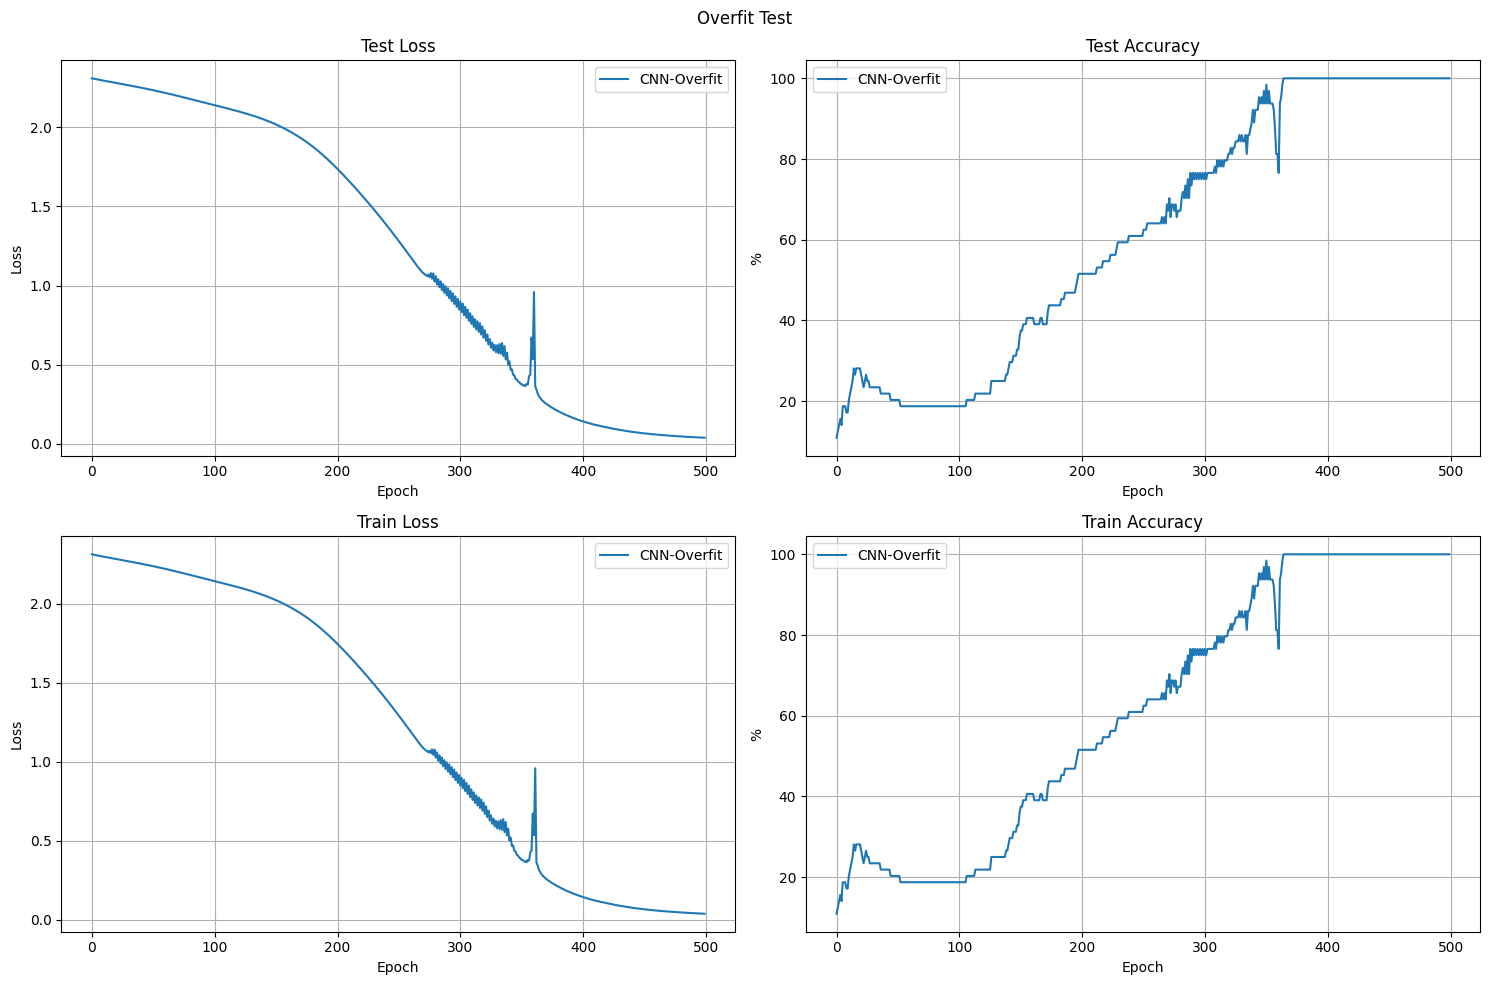

In [25]:
get_run_hist(['okkkp4r3'], ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Overfit Test')

#### Beobachtungen
Der Loss sinkt zuerst sehr schön und gleichmässig. Ab Epoche 280 passiert jedoch etwas komisches. Der Loss fängt an zu zittern. Die Accuracy steigt jedoch weiter an. Ab Epoche 380 ist die Accuracy bei 100%.

#### Interpretation
Das Modell und der dazugehörige Code funktioniert. Das Logging mit Wandb funktioniert ebenfalls. Das Modell lernt. 

## Einfache CNN-Modelle
### Base Model
Nun Trainiere ich das Base Model. Dieses hat zwei Convolutional-Layer und drei Fully-Connected-Layer.


In [26]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax
        return x


batch_size = 32
learning_rate = 0.005
epochs = 50

if run_models:
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    baseModel = BaseModel()
    optimizer = optim.SGD(baseModel.parameters(), lr=learning_rate)
    
    model_class = HelperClass(baseModel, criterion, optimizer)
    
    train_loader, test_loader = prepare_data(batch_size)
    
    dict = {
                "dataset": "CIFAR-10-Normalized",
                "epochs": epochs,
                "linear_layers": 3,
                "learning_rate": learning_rate,
                "architecture": "CNN",
                "batch_size": batch_size,
                "conv_layers": 2,
            }
    
    wandb_login(dict)
    
    trained_model = model_class.train(train_loader, test_loader, epochs)

#### Analyse

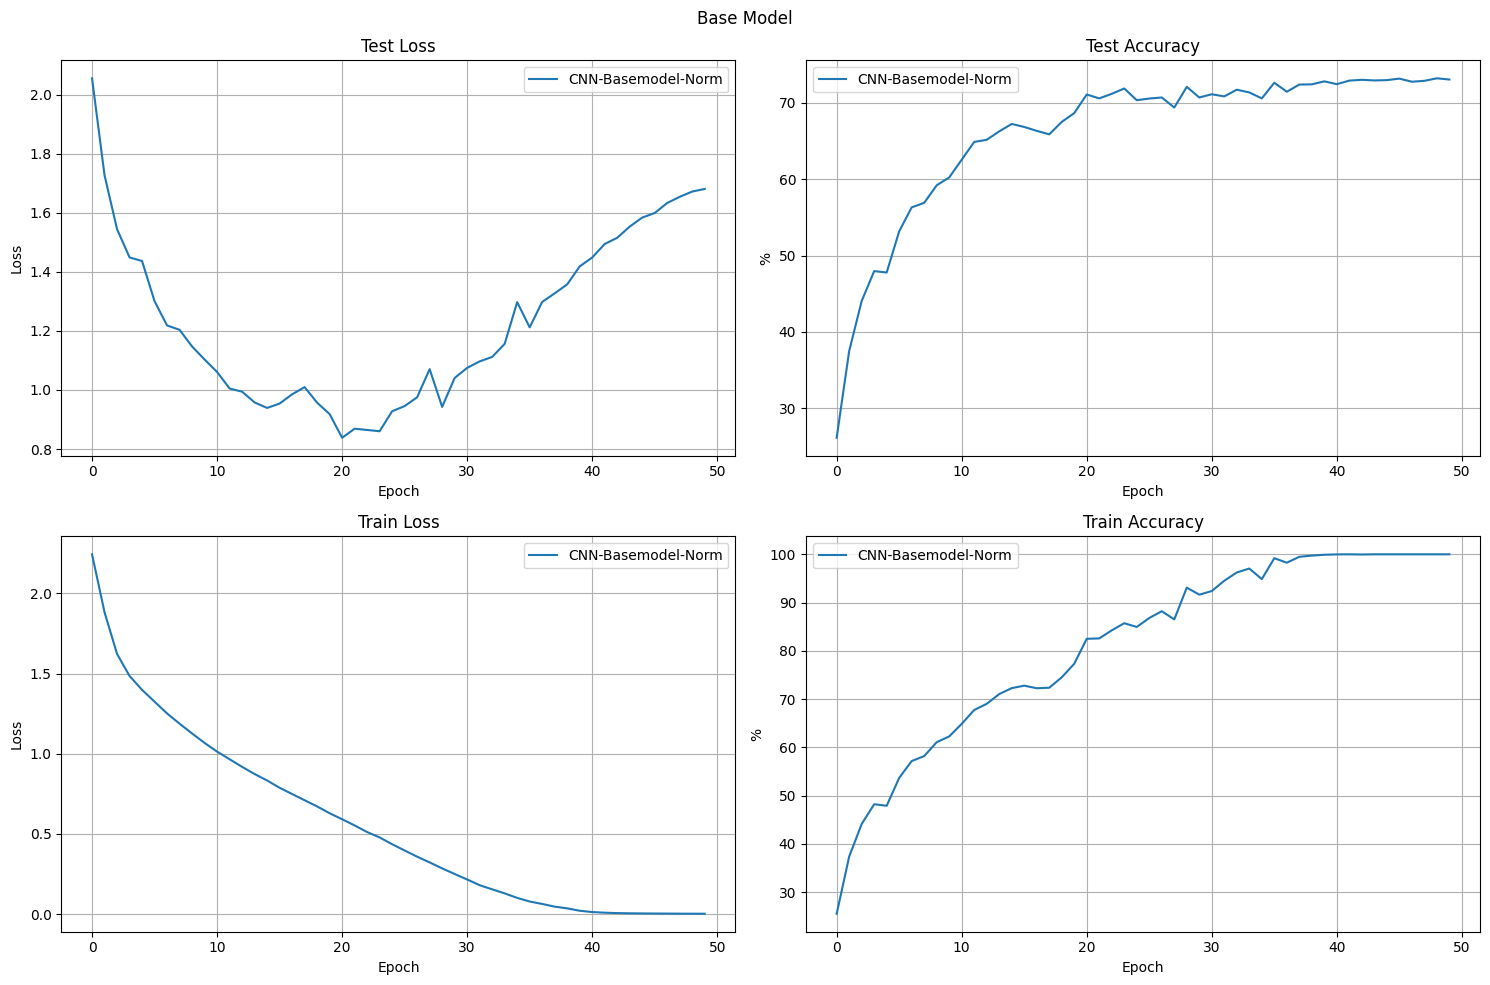

In [27]:
get_run_hist(['39s6q7ch'], ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Base Model')

##### Beobachtung
- Ab der Epoche 23 steigt der Test-Loss wieder an.
- Die Test-Accuracy ist mit ca. 70% gut für ein Basismodell
- Die Train-Accuracy steigt auf 100%.

##### Interpretation
Das Modell lernt gut aber es overfittet schnell. Es ist jedoch ein gutes Basismodell.


## Hyperparameter Tuning
### Learning Rate
Um mehrere Learning Rates zu testen habe ich eine For-Loop implementiert. Ich teste die Learning Rates 0.0001, 0.001, 0.01, 0.1 und 1. 

In [28]:
class LearningRatesModel(nn.Module):
    def __init__(self):
        super(LearningRatesModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x


batch_size = 32
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
epochs = 50

if run_models:

    for learning_rate in learning_rates:
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Optimizer
        learningRatesModel = LearningRatesModel()
        optimizer = optim.SGD(learningRatesModel.parameters(), lr=learning_rate)
        
        model_class = HelperClass(learningRatesModel, criterion, optimizer)
        
        train_loader, test_loader = prepare_data(batch_size)
        
        dict = {
                    "dataset": "CIFAR-10",
                    "epochs": epochs,
                    "linear_layers": 3,
                    "learning_rate": learning_rate,
                    "architecture": "CNN",
                    "batch_size": batch_size,
                    "conv_layers": 2,
                }
        
        wandb_login(dict)
        
        trained_model = model_class.train(train_loader, test_loader, epochs)


#### Analyse

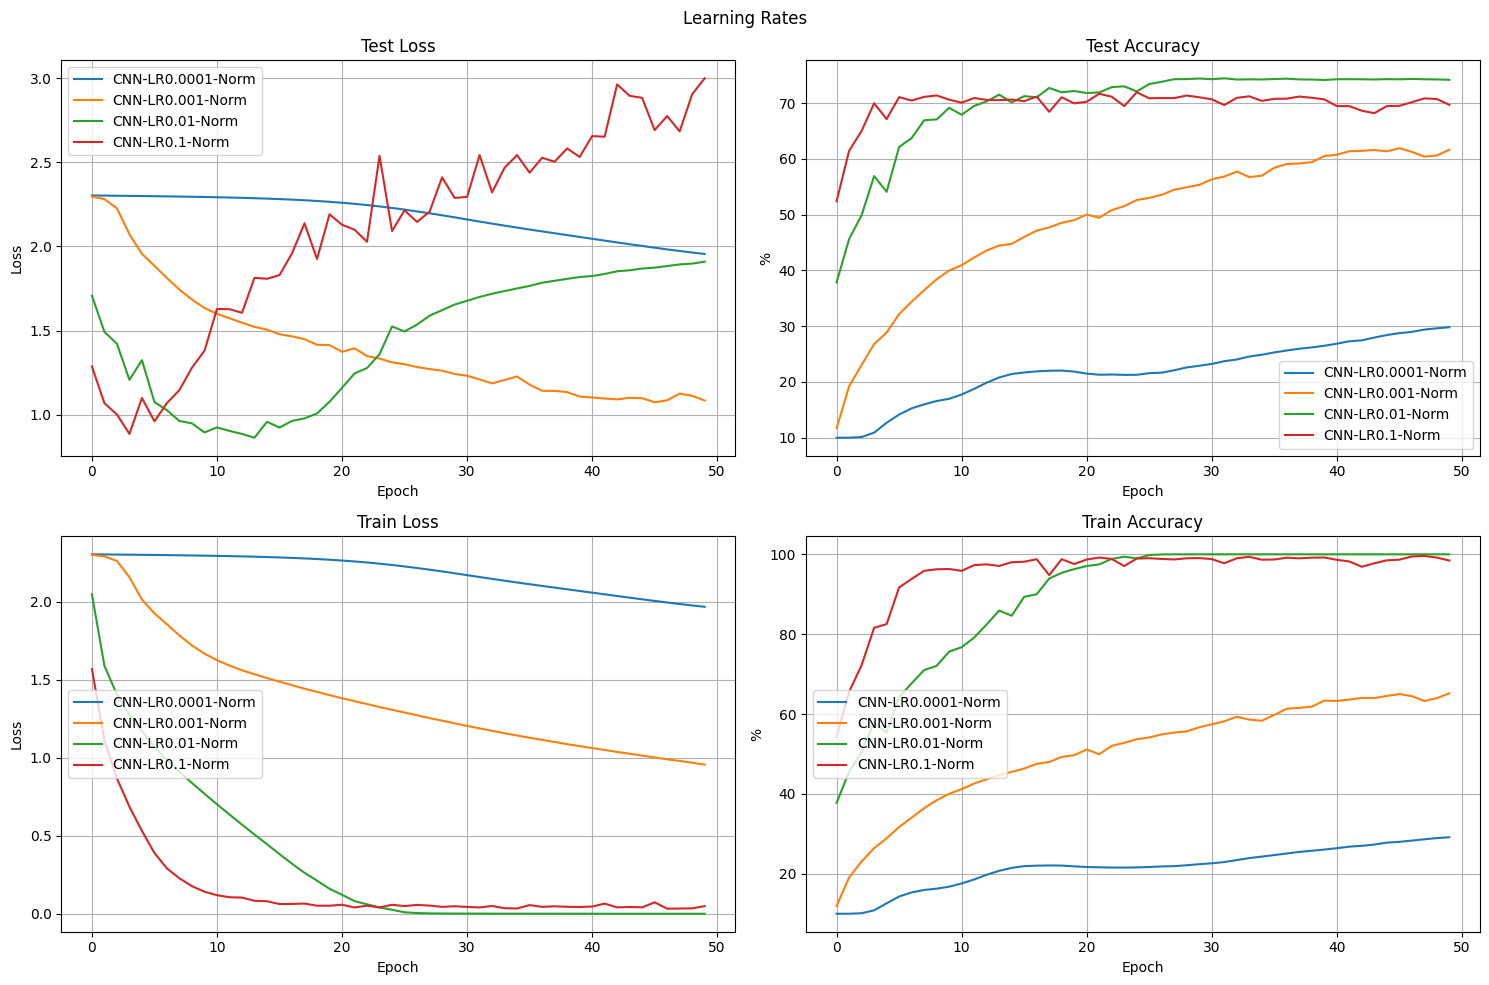

In [29]:
get_run_hist(['i9obsbxs', 'qa5183ij', 'wmvqyhr8', 'o8j4v18p'], ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Learning Rates')

##### Beobachtung
- Bei Learning Rate 0.0001 verändert sich der Loss kaum.
- Bei LR 0.001 scheint es zu wenige Epochen gegeben zu haben.
- Bei LR 0.1 steigt der Loss bereits ab Epoche 5 wieder stark an.
- LR 1 ergibt beim Loss nan-Values. Deswegen ist dieser nicht visualisiert.

##### Interpretation
- Die Learning Rate 0.0001 ist zu klein. Das Modell bräuchte zu viele Epochen um zu konvergieren.
- Die Learing Rate 0.001 scheint ebenfalls von diesem Problem betroffen zu sein. Es konvergiert schneller, aber immer noch nicht schnell genug.
- Die Learning Rate 1 ist zu hoch. Das Modell divergiert.
Aus diesem Experiment leite ich ab das eine Learning Rate um 0.01 am besten geeignet ist. 

### Batch Size

In [30]:
class BatchSizesModel(nn.Module):
    def __init__(self):
        super(BatchSizesModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

# Base Model ist 32
batch_sizes = [8, 16, 64, 128, 256]
#batch_sizes = [32]
# Base Model ist 0.005
learning_rate = 0.005
epochs = 50
if run_models:
    for batch_size in batch_sizes:
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Optimizer
        batchSizesModel = BatchSizesModel()
        optimizer = optim.SGD(batchSizesModel.parameters(), lr=learning_rate)
        
        model_class = HelperClass(batchSizesModel, criterion, optimizer)
        
        train_loader, test_loader = prepare_data(batch_size)
        
        dict = {
                    "dataset": "CIFAR-10",
                    "epochs": epochs,
                    "linear_layers": 3,
                    "learning_rate": learning_rate,
                    "architecture": "CNN",
                    "batch_size": batch_size,
                    "conv_layers": 2,
                }
        
        wandb_login(dict)
        
        trained_model = model_class.train(train_loader, test_loader, epochs)

#### Analyse

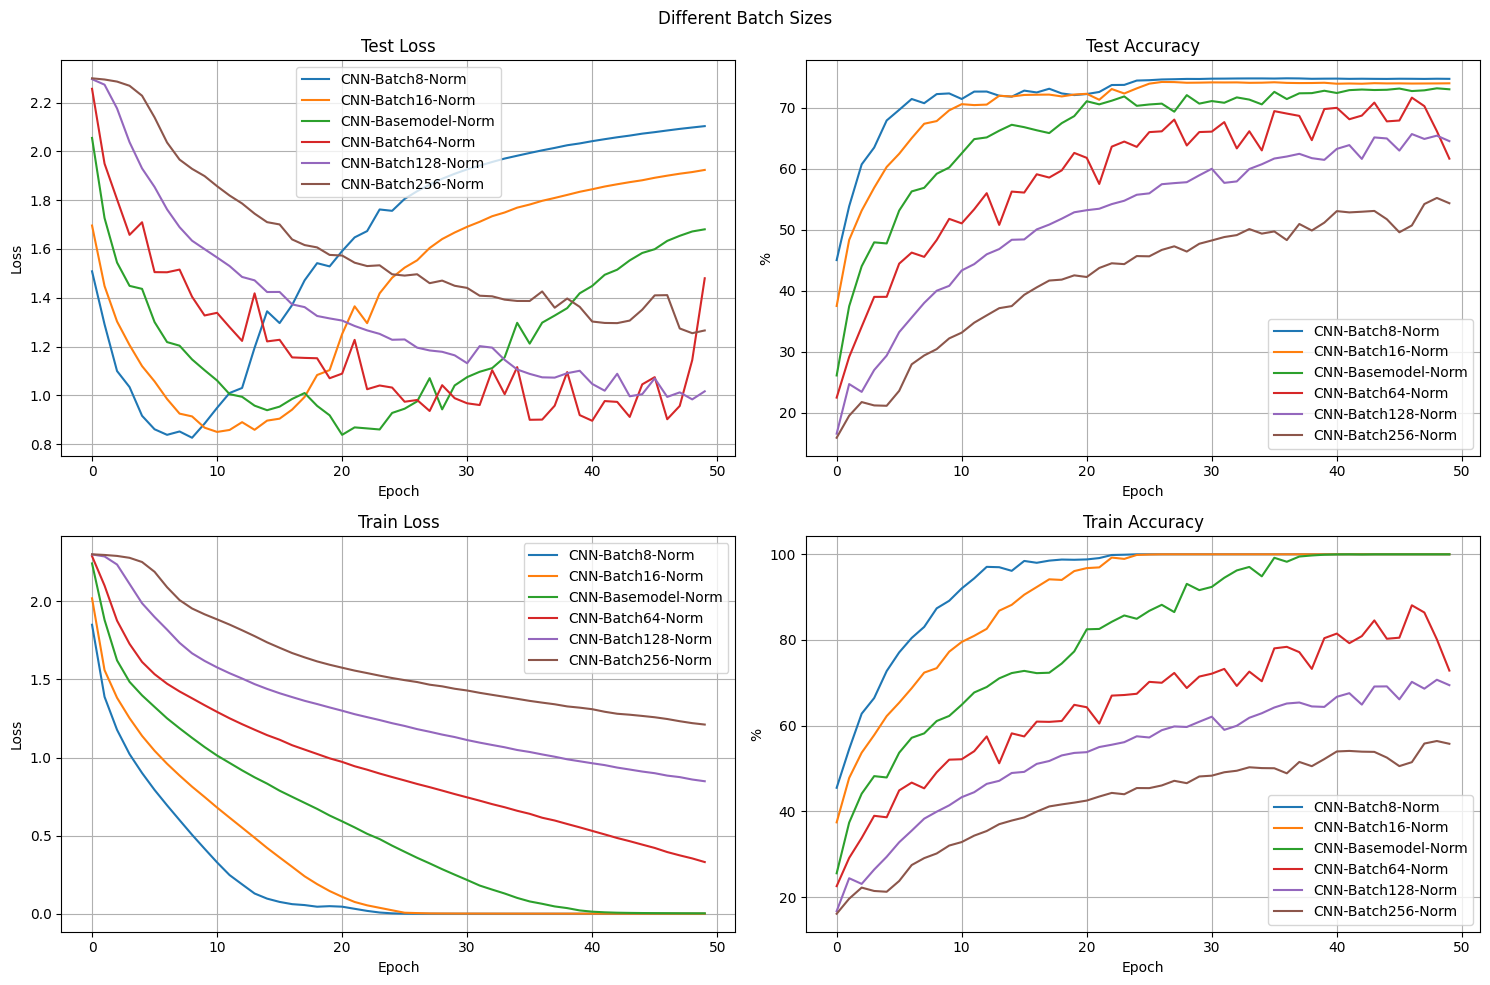

In [31]:
get_run_hist(['c0xtca4y', 'gdisivsu', '39s6q7ch', 'anvf24m2', 'v538sddu', '9isa4f43'], ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Different Batch Sizes')

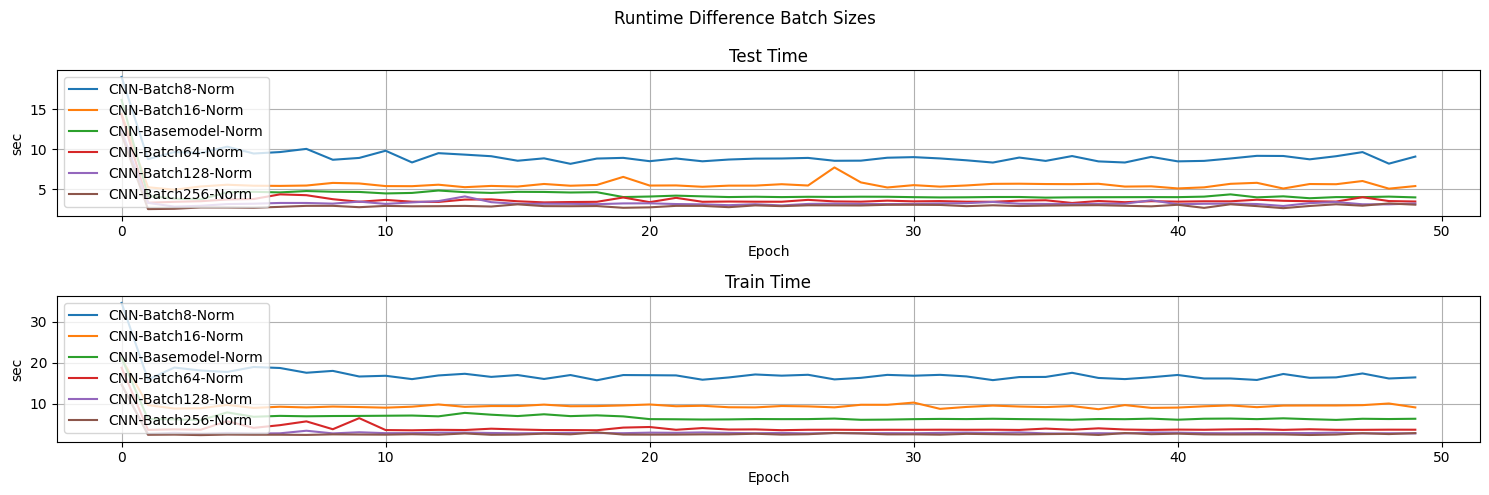

In [32]:
get_run_hist(['c0xtca4y', 'gdisivsu', '39s6q7ch', 'anvf24m2', 'v538sddu', '9isa4f43'], ['time_test', 'time_train'], ['Test Time', 'Train Time'], 'Runtime Difference Batch Sizes')

##### Beobachtung
- Je kleiner die Batch Size, desto langsamer ist das Training.
- Je kleiner die Batch Size, desto schneller steigt die Accuracy.
- Je kleiner die Batch Size, desto schneller fällt das Modell in ein Overfitting.

##### Interpretation
- Durch eine kleine Batchsize werden die Gewichte viel häufiger aktualisiert. Das Modell lernt schneller, fällt aber gleichzeitig auch schneller in ein Overfitting.
- Je grösser die Batch Size, desto schneller ist das Training pro Epoche. 
- Die grossen Batch Sizes haben zu wenige Epochen um fertig zu konvergieren. Sie würden mehr Epochen benötigen.
- Die Batch Size 16 oder 32 (Base Model) scheinen am besten geeignet zu sein.



 ## Fehlerschätzung
 Um den Fehler durch die Datenauswahl zu schätzen, werde ich eine 10-Fold Cross-Validation durchführen. Ich verwende das Base Model.
 
### 10-Fold Cross-Validation
Die Zehnfach-Cross-Validierung wird für die Bewertung der Modellleistung verwendet. Dazu wird der Datensatz in zehn gleich große Folds aufgeteilt, von denen in jedem Durchlauf ein anderer Fold als Testdatensatz dient. Die verbleibenden neun Folds werden für das Training genutzt, wodurch der Prozess insgesamt zehnmal wiederholt wird. Am Ende wird vom Ergebniss der Durchschnitt genommen, um eine Gesamtbewertung des Modells zu erhalten. Diese Technik hilft, Overfitting zu erkennen und den Fehler welcher das Modell macht, einschätzen zu können. 
Ein Nachteil ist aber die grosse Rechenzeit. Für eine 10-Fold Cross-Validation wird das Modell zehnmal trainiert und getestet. Das bedeutet, dass die Rechenzeit zehnmal so gross ist wie normalerweise.
 

In [33]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

class FehlerschätzModel(nn.Module):
    def __init__(self):
        super(FehlerschätzModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax
        return x


batch_size = 32
learning_rate = 0.005
epochs = 50

if run_models:

    kFold = KFold(n_splits=10, shuffle=True, random_state=42)
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])
        
    training_data = datasets.CIFAR10(
            root="data",
            train=True,
            download=True,
            transform=transform
        )
    
    
    for fold_num, (train_indices, test_indices) in enumerate(kFold.split(training_data)):
        
        sampler_train = SubsetRandomSampler(train_indices)
        sampler_test = SubsetRandomSampler(test_indices)
            
        train_loader = DataLoader(training_data, batch_size=batch_size, sampler=sampler_train, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
        test_loader = DataLoader(training_data, batch_size=batch_size, sampler=sampler_test, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
        
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Optimizer
        fehlerschätzModel = FehlerschätzModel()
        optimizer = optim.SGD(fehlerschätzModel.parameters(), lr=learning_rate)
        
        model_class = HelperClass(fehlerschätzModel, criterion, optimizer)
        
        #train_loader, test_loader = prepare_data(batch_size)
        
        dict = {
                    "dataset": "CIFAR-10-Normalized",
                    "epochs": epochs,
                    "linear_layers": 3,
                    "learning_rate": learning_rate,
                    "architecture": "CNN",
                    "batch_size": batch_size,
                    "conv_layers": 2,
                }
        
        wandb_login(dict)
        
        trained_model = model_class.train(train_loader, test_loader, epochs)

#### Analyse

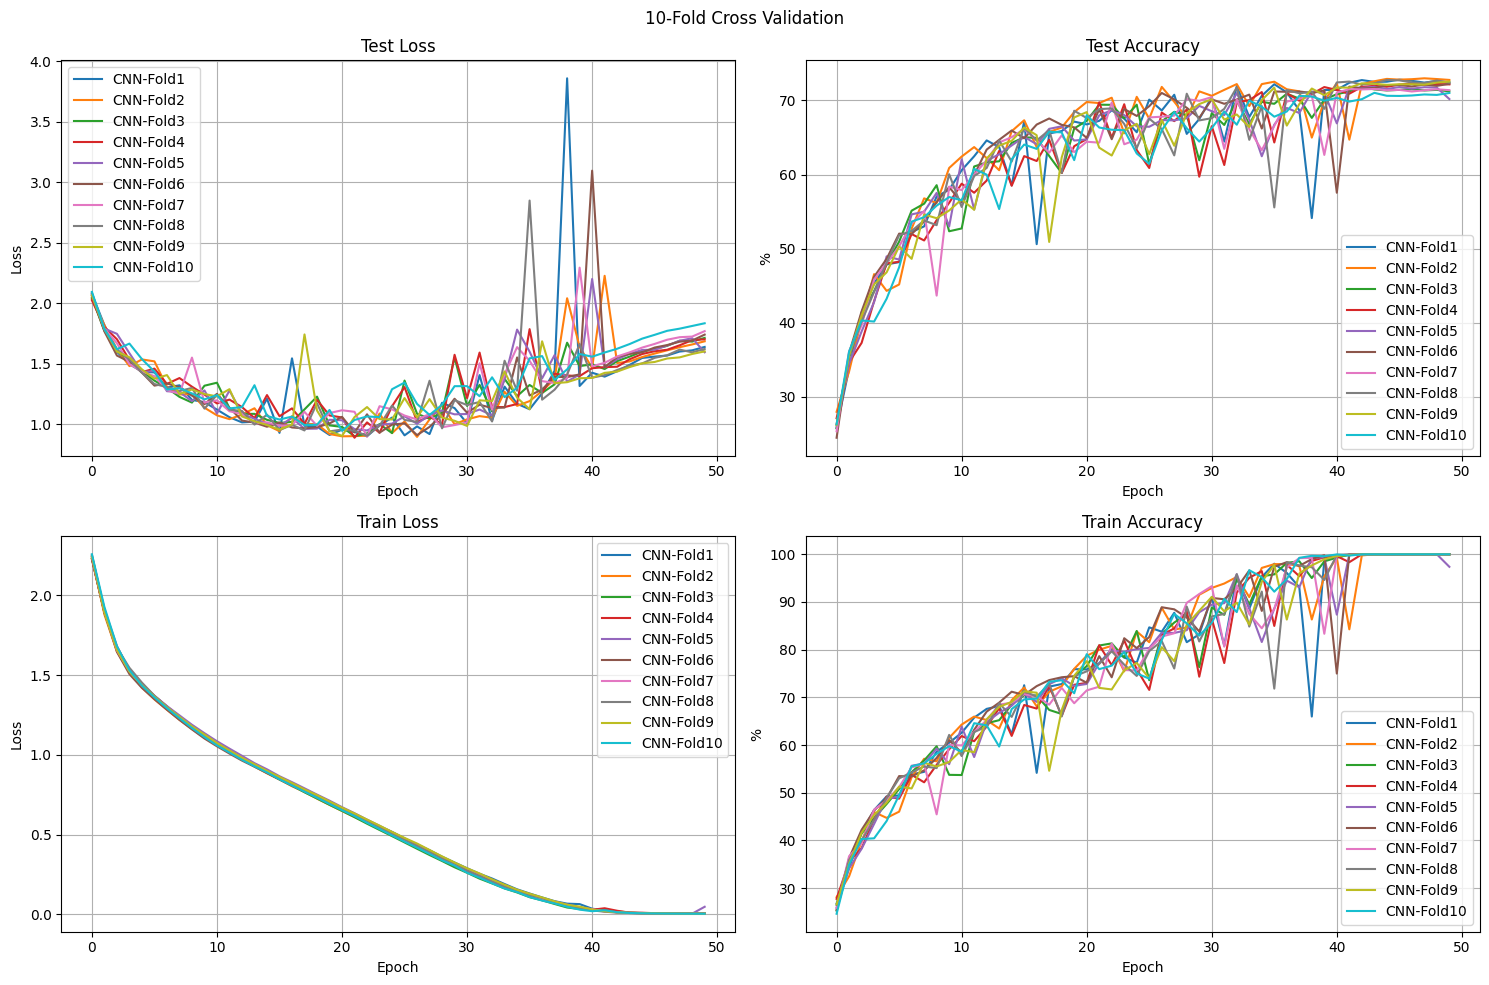

In [34]:
runs=['t9qku6es', 'itb4tvnv', 'c7949ynr', 'glf2r5g9', '1r4fb3yc', 'eakpy7j4', '6n1wdmu8', 'r4l7bnz1', '97wd10r0', 'nvy8zta5']
get_run_hist(runs, ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], '10-Fold Cross Validation')

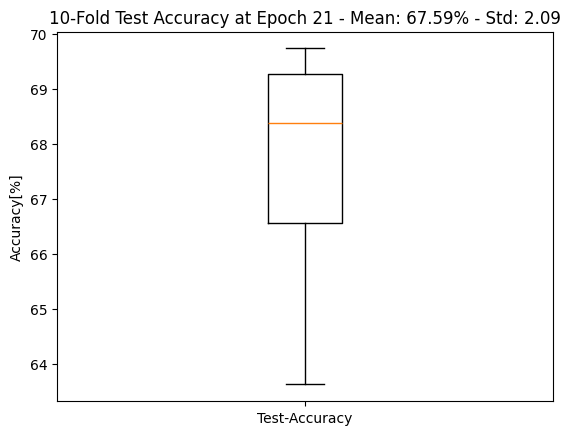

In [35]:
accuracys = []
api = wandb.Api()
for run_id in runs:
    run = api.run(path=f'del-MC1/{run_id}')
    # Get accuracy at epoch 21
    hist = run.history()
    accuracys.append(hist['test_accuracy'][21])
    
mean = np.mean(accuracys)
std = np.std(accuracys)

plt.boxplot(accuracys)
plt.title(f'10-Fold Test Accuracy at Epoch 21 - Mean: {mean}% - Std: {std:.2f}')
plt.ylabel('Accuracy[%]')
plt.xticks([1], ['Test-Accuracy'])
plt.show()
    

##### Beobachtung
- Alle Folds schneiden sehr ähnlich ab.
- Sie Overfitten etwa ab Epoche 21.
- Zwischen Epoche 30 und 40 ist der Loss sowie die Accuracy sehr instabil.

##### Interpretation
- Die Folds sind sehr ähnlich. Der Fehler durch die Datenauswahl ist eher gering.
- Fold 1 und 7 scheinen etwas schlechter abzuschneiden. Dies könnte durch eine schlechte Datenauswahl entstanden sein.
- Für ein Basis-Modell ist die Test-Accuracy von ca. 68% gut.



# Schritt 4 
## Initialisierung der Gewichte
Die Weight-Initialization trägt zu einem schnelleren und stabileren Training bei. Es gibt verschiedene Methoden um die Gewichte zu initialisieren.
Sie alle haben das Ziel, dass die Gewichte nicht zu gross oder zu klein sind, um Exploding oder Vanishing Gradients zu verhindern.
Die Gewichte werden immer beim Erstellen des Modells initialisiert. Standardmässig werden die Gewichte mit Kaiming-He initialisiert.
Nachfolgend habe ich einige Initialisierungen beschrieben, implementiert und getestet.

### Zero-Initialization
Wie der Name schon sagt, werden alle Gewichte auf 0 gestzt.

In [36]:
class ZeroInitModel(nn.Module):
    def __init__(self):
        super(ZeroInitModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        # Gewichte Initialisierung
        nn.init.zeros_(self.conv1.weight)
        nn.init.zeros_(self.conv2.weight)
        nn.init.zeros_(self.fc1.weight)
        nn.init.zeros_(self.fc2.weight)
        nn.init.zeros_(self.fc3.weight)
        
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


batch_size = 32
learning_rate = 0.005
epochs = 50

if run_models:
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    zeroInitModel = ZeroInitModel()
    optimizer = optim.SGD(zeroInitModel.parameters(), lr=learning_rate)
    
    model_class = HelperClass(zeroInitModel, criterion, optimizer)
    
    train_loader, test_loader = prepare_data(batch_size)
    
    dict = {
                "dataset": "CIFAR-10-Normalized",
                "epochs": epochs,
                "linear_layers": 3,
                "learning_rate": learning_rate,
                "architecture": "CNN",
                "batch_size": batch_size,
                "conv_layers": 2,
            }
    
    wandb_login(dict)
    
    trained_model = model_class.train(train_loader, test_loader, epochs)

#### Analyse

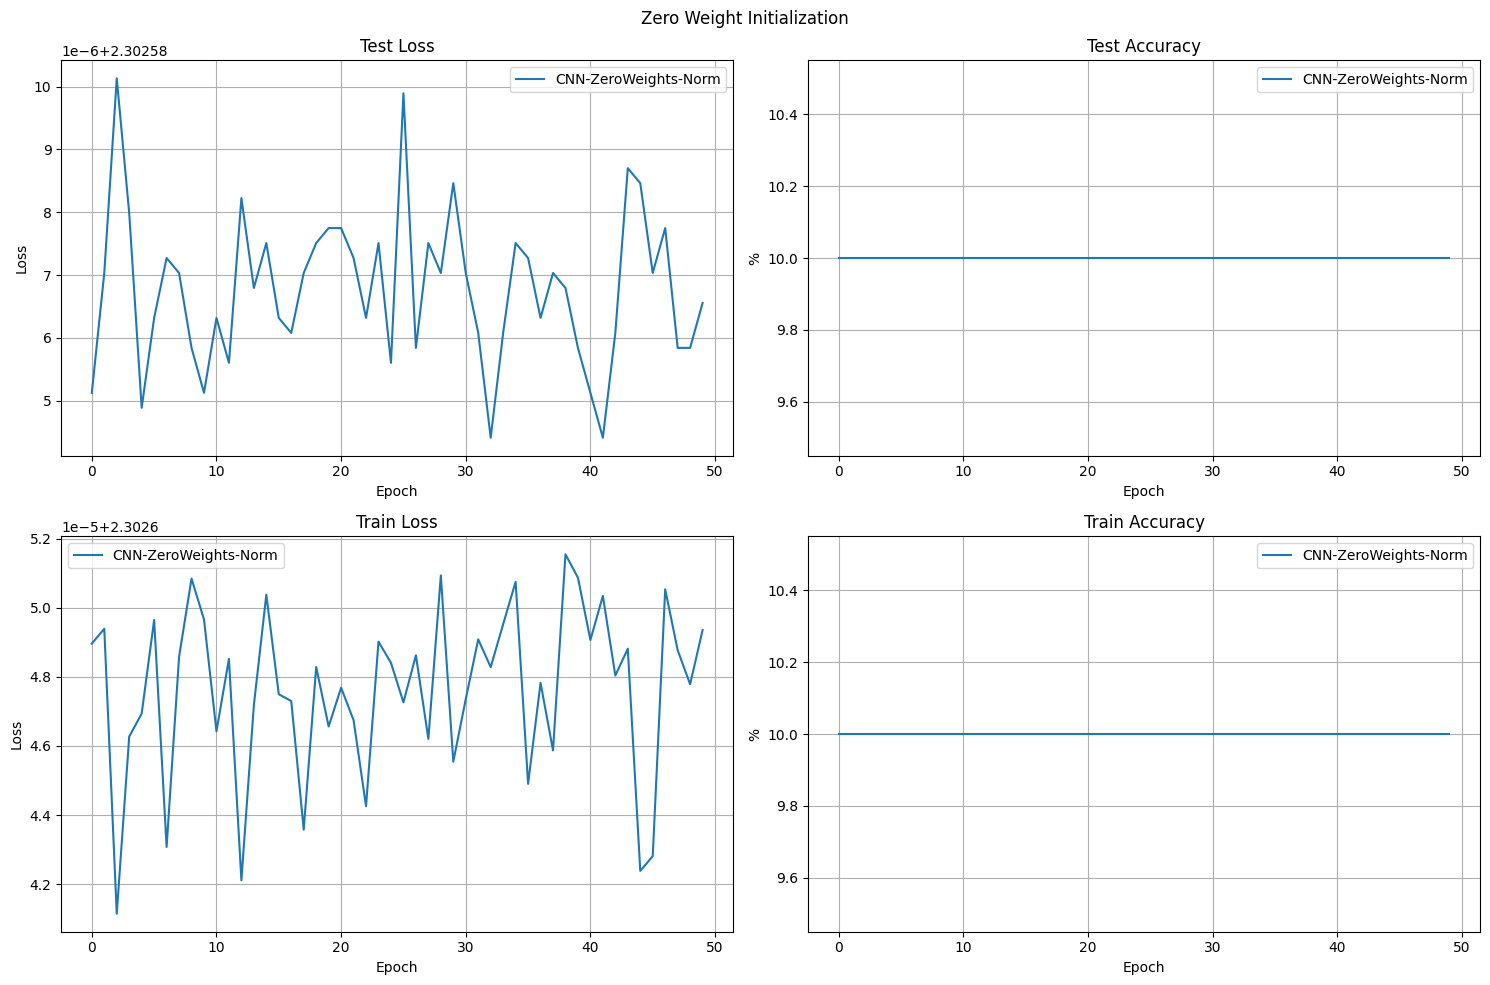

In [37]:
get_run_hist(['vzefg3l3'], ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Zero Weight Initialization')

#### Beobachtung
- Der Loss springt wild umher
- Die Accuracy bleibt bei 10%, was dem Zufall entspricht.


#### Interpretation
- Die Zero-Initialization ist nicht geeignet. Da alle Gewichte Null sind, ist in der Backpropagation nicht nachvollziehbar, welcher Gewichtsgradient zu welchem Gewicht gehört und somit welchen Einluss er auf das Ergebniss hat




### Random-Initialization
Bei der Random-Initialization werden die Gewichte anhand einer Normalverteilung mit einem Mittelwert von 0 und einer Standardabweichung von 0.01 initialisiert.
Das Ziel ist, dass die Gewichte einen Zufall enthalten und somit die Backpropagation funktioniert. 

In [38]:
 class NormalInitModel(nn.Module):
    def __init__(self):
        super(NormalInitModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        # Gewichte Initialisierung
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.fc3.weight, mean=0.0, std=0.01)
        
        nn.init.normal_(self.conv1.bias, mean=0.0, std=0.01)
        nn.init.normal_(self.conv2.bias, mean=0.0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0.0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0.0, std=0.01)
        nn.init.normal_(self.fc3.bias, mean=0.0, std=0.01)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


batch_size = 32
learning_rate = 0.005
epochs = 50

if run_models:
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    normalInitModel = NormalInitModel()
    optimizer = optim.SGD(normalInitModel.parameters(), lr=learning_rate)
    
    model_class = HelperClass(normalInitModel, criterion, optimizer)
    
    train_loader, test_loader = prepare_data(batch_size)
    
    dict = {
                "dataset": "CIFAR-10-Normalized",
                "epochs": epochs,
                "linear_layers": 3,
                "learning_rate": learning_rate,
                "architecture": "CNN",
                "batch_size": batch_size,
                "conv_layers": 2,
            }
    
    wandb_login(dict)
    
    trained_model = model_class.train(train_loader, test_loader, epochs)

#### Analyse

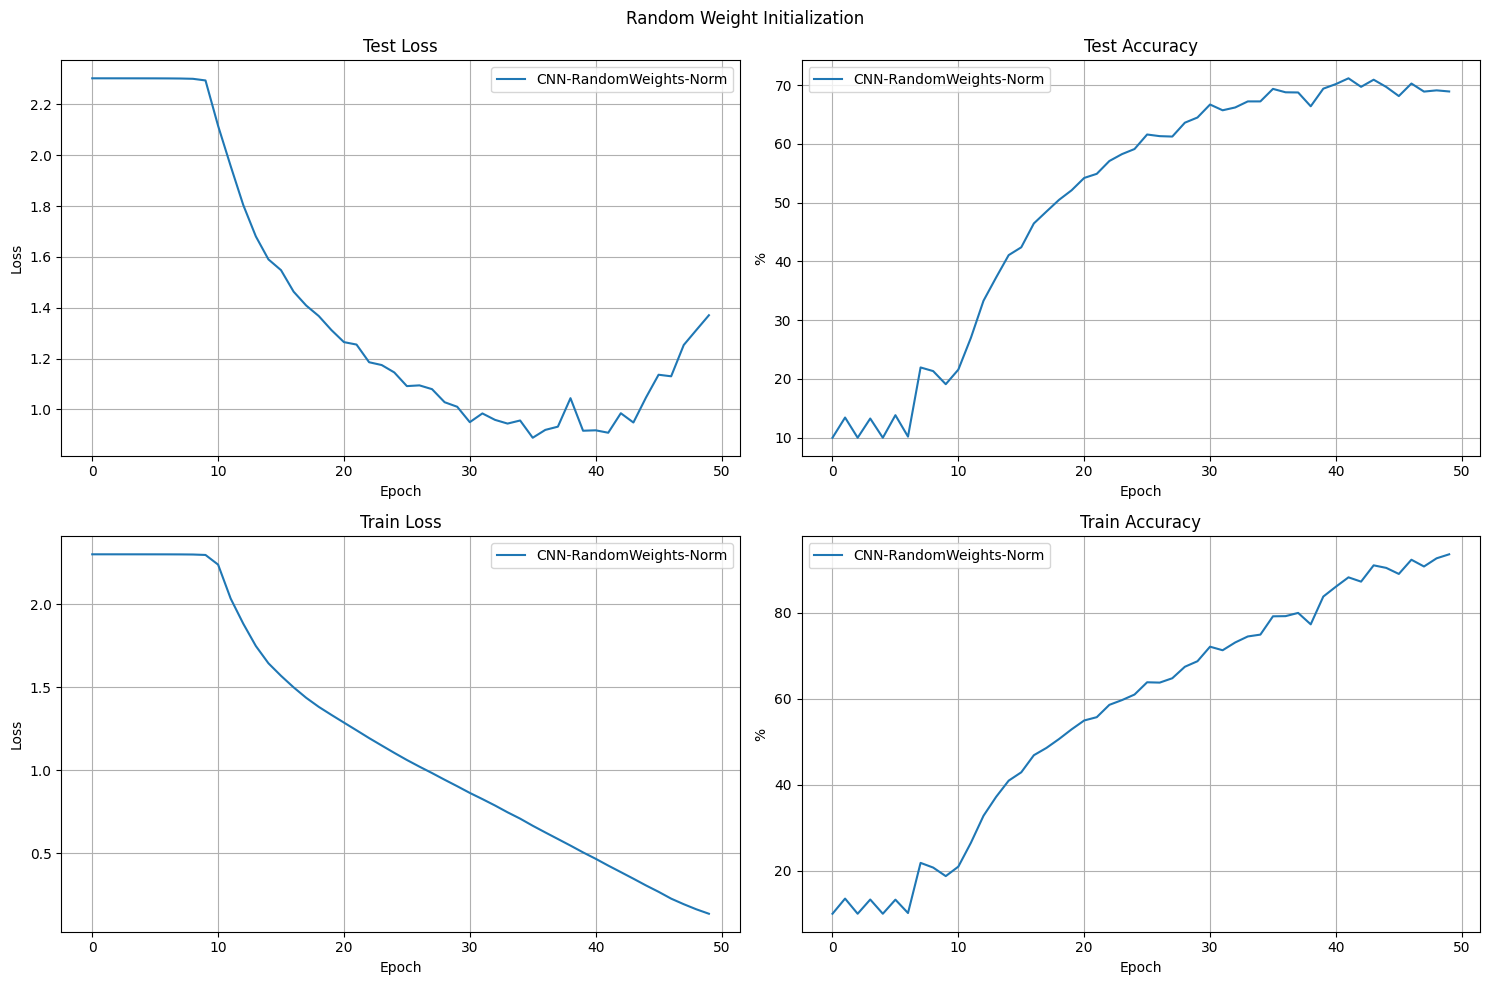

In [39]:
get_run_hist(['9cus4xsk'], ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Random Weight Initialization')

#### Beobachtung
- Die ersten Epochen lernt das Modell nichts
- Ab Epoche 9 sinkt der Loss und die Accuracy steigt
- Ab Epoche 41 overfittet das Modell

#### Interpretation
- Die Random-Initalization ist besser als Zero-Initialization
- Der Loss braucht länger um zu konvergieren

### Xavier-Initialization
Die Initialisierung der Gewichte wird anhand einer Normalverteilung mit einem Mittelwert von 0 und einer Standardabweichung welche so berechnet wird
$$
\text{std} = \sqrt{\frac{2}{\text{fan\_in} + \text{fan\_out}}}
$$
gemacht.
fan_in ist die Anzahl der Inputs und fan_out die Anzahl der Outputs.

Vorteil dieser Methode ist, dass die Standardabweichung von den In- und Outputs abhängt. Je grösser die In- und Outputgrössen, desto kleiner wird die Standardabeichung.
Dies macht die Xavier-Initialisierung deutlich weniger anfällig gegen Exploding oder Vanishing Gradients.

Ich habe Anfangs den Fehler gemacht und die Gewichte der Convolutional-Layer ebenfalls initialisiert. Dies ist aber nicht unbedingt nötig da die Gewichte der CNN-Layers nicht von Exploding oder Vanishing Gradients betroffen sind. 

In [40]:
 class XavierInitModel(nn.Module):
    def __init__(self):
        super(XavierInitModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        # Gewichte Initialisierung
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
    
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


batch_size = 32
learning_rate = 0.005
epochs = 50

if run_models:
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    xavierInitModel = XavierInitModel()
    optimizer = optim.SGD(xavierInitModel.parameters(), lr=learning_rate)
    
    model_class = HelperClass(xavierInitModel, criterion, optimizer)
    
    train_loader, test_loader = prepare_data(batch_size)
    
    dict = {
                "dataset": "CIFAR-10-Normalized",
                "epochs": epochs,
                "linear_layers": 3,
                "learning_rate": learning_rate,
                "architecture": "CNN",
                "batch_size": batch_size,
                "conv_layers": 2,
            }
    
    wandb_login(dict)
    
    trained_model = model_class.train(train_loader, test_loader, epochs)

Anpassung der Aktivierungsfunktion auf Sigmoid, da die Gewichte mit Xavier-Initialisierung initialisiert wurden.

In [41]:
class XavierInitModel(nn.Module):
    def __init__(self):
        super(XavierInitModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        # Gewichte Initialisierung
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
    
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


batch_size = 32
learning_rate = 0.005
epochs = 50

if run_models:
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    xavierInitModel = XavierInitModel()
    optimizer = optim.SGD(xavierInitModel.parameters(), lr=learning_rate)
    
    model_class = HelperClass(xavierInitModel, criterion, optimizer)
    
    train_loader, test_loader = prepare_data(batch_size)
    
    dict = {
                "dataset": "CIFAR-10-Normalized",
                "epochs": epochs,
                "linear_layers": 3,
                "learning_rate": learning_rate,
                "architecture": "CNN",
                "batch_size": batch_size,
                "conv_layers": 2,
            }
    
    wandb_login(dict)
    
    trained_model = model_class.train(train_loader, test_loader, epochs)

#### Analyse

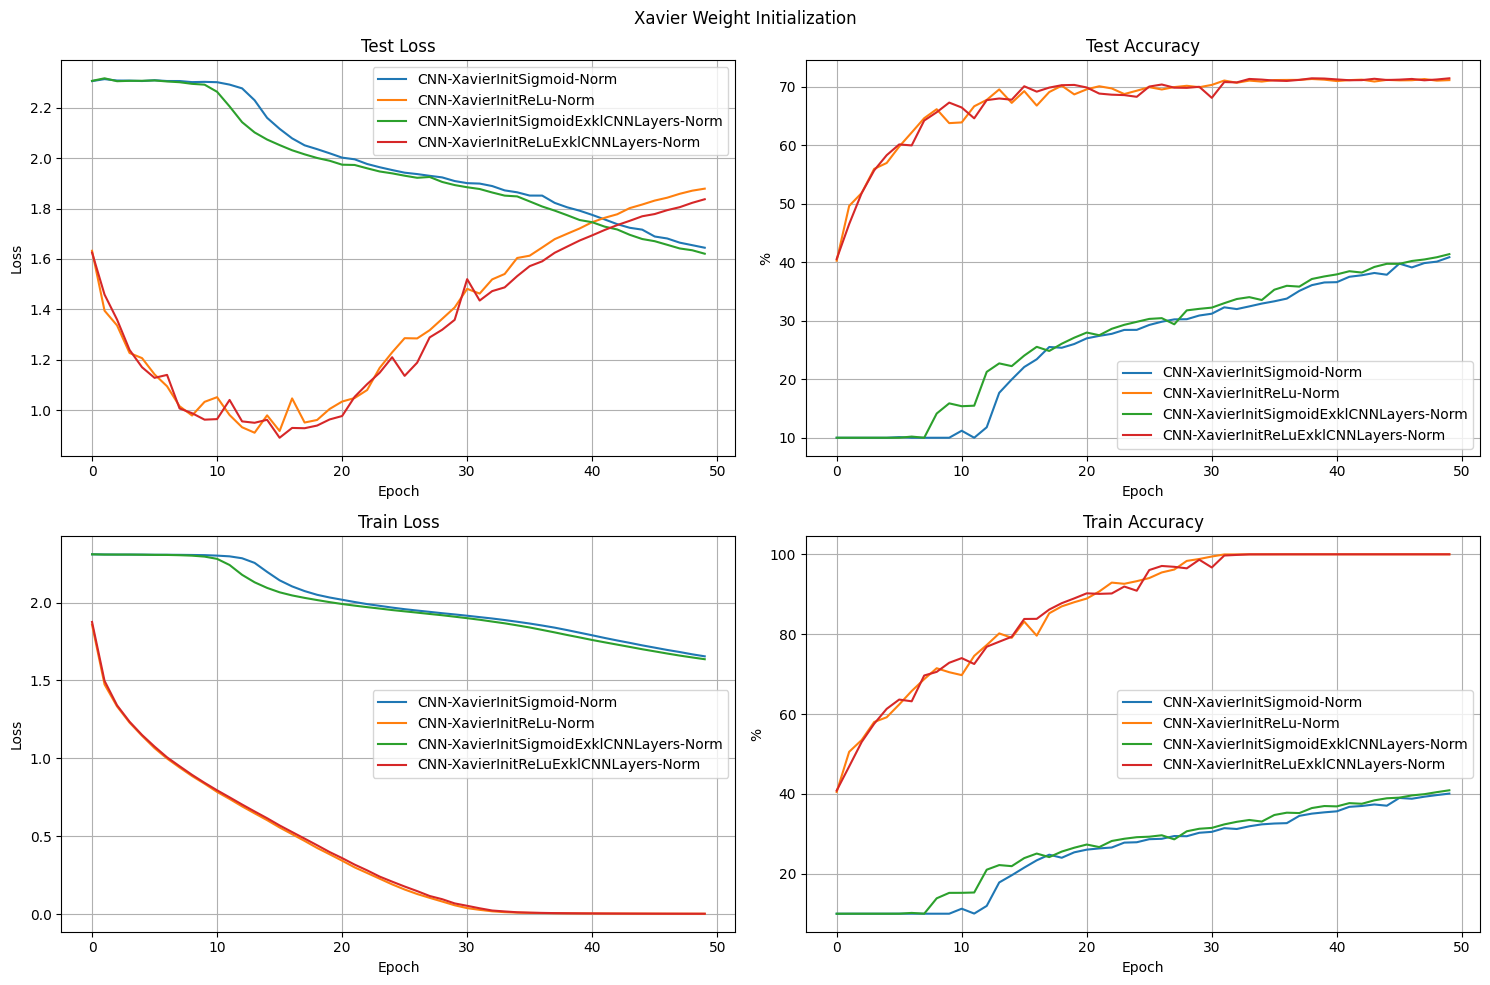

In [42]:
get_run_hist(['vv9xi128', 'hp4dyxst', 'kreu5i1a', 'ykcev7pe'], ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Xavier Weight Initialization')

##### Beobachtung
- Die Modelle mit der ReLU Aktivierungsfunktion scheinen besser abzuschneiden. Sie Overfitten ab etwa Epoche 16
- Die Modelle mit der Sigmoid Aktivierungsfunktion scheinen schlechter abzuschneiden
- Die Initialisierung der Convolutional Layer scheint keinen Einfluss zu haben 

##### Interpretation
- Die Sigmoid Aktivierungsfunktion scheint mehr Epochen zu benötigen um komplett zu konvergieren
- Die Initialisierung der Convolutional Layer scheint keinen Einfluss auf das Ergebniss zu haben

### He-Initialization (Standard)
Die Kaiming-He Initialisierung ist, genau wie die Xavier-Initialisierung, eine modifizierte Initialisierung der Gewichte durch eine Normalverteilung.
Die Standardabweichung wird jedoch anders berechnet:
$$
\text{std} = \sqrt{\frac{2}{\text{fan\_in}}}
$$
Im vergleich zur Xavier-Initialisierung wird nur die Anzahl der Inputs berücksichtigt. Dies führt zu einer grösseren Standardabweichung und somit zu einer grösseren Varianz der Gewichte.
Sie soll für die ReLU Aktivierungsfunktion besser geeignet sein. 

Folgendes Modell entspricht dem Basis-Modell, da die Gewichte in Pytorch standardmässig immer mit der Kaiming-He Initialisierung initialisiert werden.

In [43]:
 class HeInitModel(nn.Module):
    def __init__(self):
        super(HeInitModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        # Gewichte Initialisierung
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
    
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


batch_size = 32
learning_rate = 0.005
epochs = 50

if run_models:
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    xavierInitModel = XavierInitModel()
    optimizer = optim.SGD(xavierInitModel.parameters(), lr=learning_rate)
    
    model_class = HelperClass(xavierInitModel, criterion, optimizer)
    
    train_loader, test_loader = prepare_data(batch_size)
    
    dict = {
                "dataset": "CIFAR-10-Normalized",
                "epochs": epochs,
                "linear_layers": 3,
                "learning_rate": learning_rate,
                "architecture": "CNN",
                "batch_size": batch_size,
                "conv_layers": 2,
            }
    
    wandb_login(dict)
    
    trained_model = model_class.train(train_loader, test_loader, epochs)

He-Initialization mit Sigmoid Aktivierungsfunktion als Test.

In [44]:
 class HeInitModel(nn.Module):
    def __init__(self):
        super(HeInitModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)   # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)   # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        # Gewichte Initialisierung
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
    
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


batch_size = 32
learning_rate = 0.005
epochs = 50

if run_models:
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    xavierInitModel = XavierInitModel()
    optimizer = optim.SGD(xavierInitModel.parameters(), lr=learning_rate)
    
    model_class = HelperClass(xavierInitModel, criterion, optimizer)
    
    train_loader, test_loader = prepare_data(batch_size)
    
    dict = {
                "dataset": "CIFAR-10-Normalized",
                "epochs": epochs,
                "linear_layers": 3,
                "learning_rate": learning_rate,
                "architecture": "CNN",
                "batch_size": batch_size,
                "conv_layers": 2,
            }
    
    wandb_login(dict)
    
    trained_model = model_class.train(train_loader, test_loader, epochs)

Hier habe ich noch den Unterschied zwischen dem Parameter 'fan_in' (Standard) und 'fan_out' getestet.

In [45]:
class HeInitModel(nn.Module):
    def __init__(self):
        super(HeInitModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.pool1 = nn.MaxPool2d(2, 2)  # 14*14*32
        self.conv2 = nn.Conv2d(32, 64, 5)  # 10*10*64
        self.pool2 = nn.MaxPool2d(2, 2)  # 5*5*64
        self.fc1 = nn.Linear(1600, 1024)  # 1024
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

        # Gewichte Initialisierung
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out', nonlinearity='relu')

        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Analyse

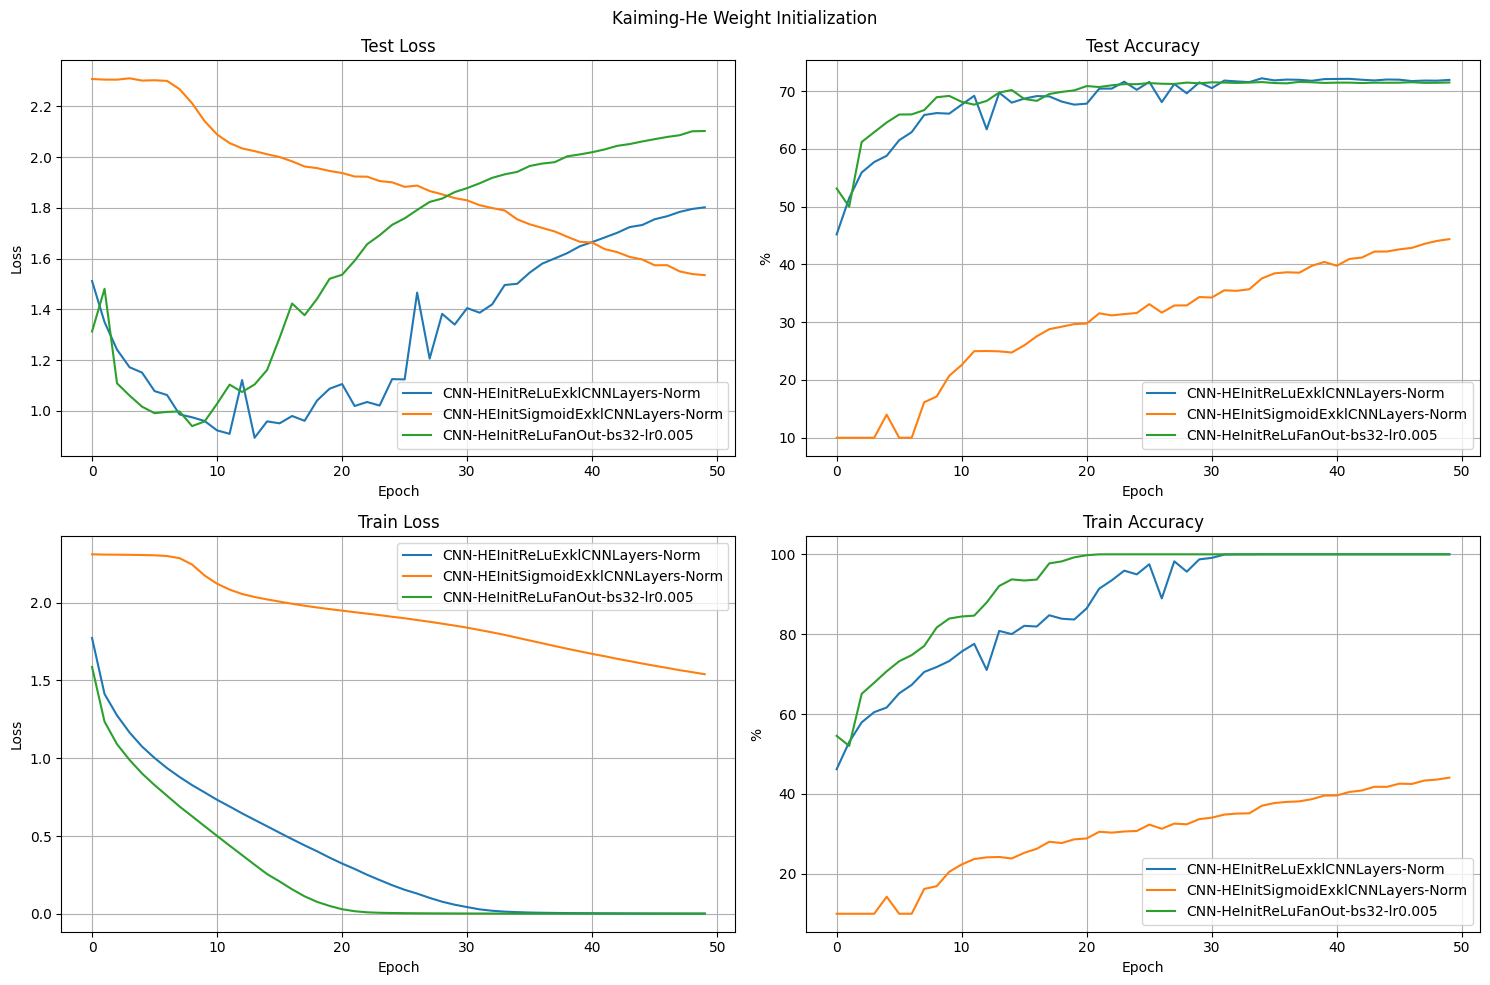

In [46]:
get_run_hist(['6a8fafhl', 'dwk268dt', 'rka62col'], ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Kaiming-He Weight Initialization')

##### Beobachtung
- Das Modell mit der Sigmoid Aktivierungsfunktion lernt viel langsamer als das Modell mit der ReLU Aktivierungsfunktion
- Der Unterschied zwischen 'fan_in' und 'fan_out' ist nicht so gross
- Das Modell mit 'fan_out' scheint etwas schneller zu lernen und landet dadruch auch schneller im Overfitting

##### Interpretation
- Für das Modell mit der Sigmoind Aktivierungsfunktion wird mehr Zeit benötigt um zu konvergieren
- Ich denke dass das Modell mit dem Parameter 'fan_out' besser mit der Backpropagation zurecht kommt 

### Analyse

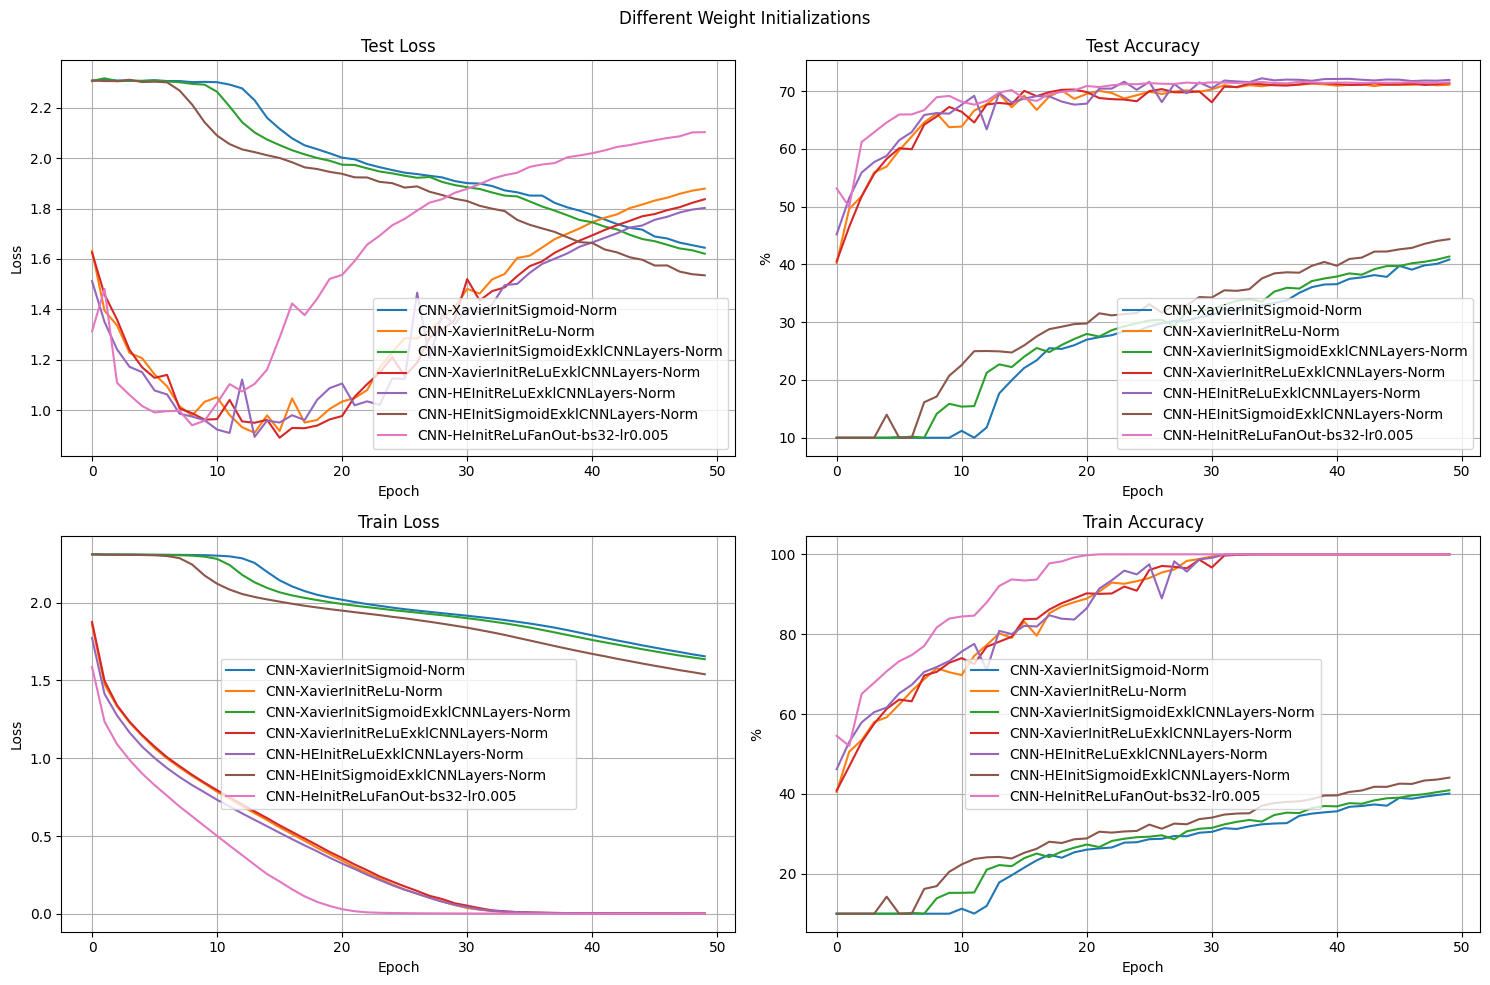

In [47]:
get_run_hist(['vv9xi128', 'hp4dyxst', 'kreu5i1a', 'ykcev7pe', '6a8fafhl', 'dwk268dt', 'rka62col'], ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'], ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Different Weight Initializations')

#### Beobachtung
- Der Hauptunterschied ist die jeweilige Aktivierungsfunktion wobei ReLU deutlich besser abschneidet
- Fan_in scheint ein wenig langsamer zu lernen als Fan_out und Xavier

#### Interpretation
- Die Initialisierungsform spielt bei diesen Daten keine grosse Rolle
- Ich belasse es bei dem Standard (He-Initialization) und ReLU Aktivierungsfunktion

## Modell-Komplexität
Ab dem "Many CNN-Layer Model" habe ich die Berechnung der Modelle auf dem SLURM-Cluster der Informatikabteilung ausgeführt. Die Änderungen am Code sind in den jeweiligen Zellen dokumentiert. Der grobe Aufbau ist im File runModels.py zu finden. Ich werde aber nur jeweils den besten Run pro Modell hier dokumentieren.
Da ich auf dem SLURM-Cluster genug Rechnkapazität und Zeit gehabt habe, habe ich pro Modell verschiedene Batch Sizes und Learning Rates getestet. Ich werde jedoch immer nur auf das best perfomende Modell eingehen.

In [48]:
def test_model(name:str, linear_layers:int, conv_layers:int):
    batch_sizes = [16, 32, 64, 128, 256]
    learning_rates = [0.001, 0.01, 0.1]
    epochs = 25
    
    for batch_size in batch_sizes:
        for lr in learning_rates:
            deepCNNModel = DeepCNNModel()
            # Loss function
            criterion = nn.CrossEntropyLoss()
            
            # Optimizer
            optimizer = optim.SGD(deepCNNModel.parameters(), lr=lr)
            
            model_class = HelperClass(deepCNNModel, criterion, optimizer)
            
            train_loader, test_loader = prepare_data(batch_size)
            
            dict = {
                        "dataset": "CIFAR-10-Normalized",
                        "epochs": epochs,
                        "linear_layers": linear_layers,
                        "learning_rate": lr,
                        "architecture": "CNN",
                        "batch_size": batch_size,
                        "conv_layers": conv_layers,
                    }
            
            wandb_login(dict, name=f'CNN-Komplexität-{name}-bs{batch_size}-lr{lr}')
            
            trained_model = model_class.train(train_loader, test_loader, epochs)

#### Wide Model
Ich habe versucht ein breiteres Modell zu erstellen. Dazu habe ich ein weiteres Convolutional Layer hinzugefügt [3 -> 32 -> 64 -> 256]. Dadurch entstehen viel mehr Inputparameter für die Fully-Connected Layer.

In [49]:
class WideModel(nn.Module):
    def __init__(self):
        super(WideModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)  # 28*28*32
        self.conv2 = nn.Conv2d(32, 64, 5) # 24*24*64
        self.conv3 = nn.Conv2d(64, 256, 5) # 20*20*256
        self.pool1 = nn.MaxPool2d(2, 2) # 10*10*256
        self.fc1 = nn.Linear(25600, 4096)  # 1024
        self.fc2 = nn.Linear(4096, 256)
        self.fc3 = nn.Linear(256, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [50]:
if run_models:
    wideModel = WideModel()
    trained_model = test_model("WideModel", 3, 3)

##### Analyse

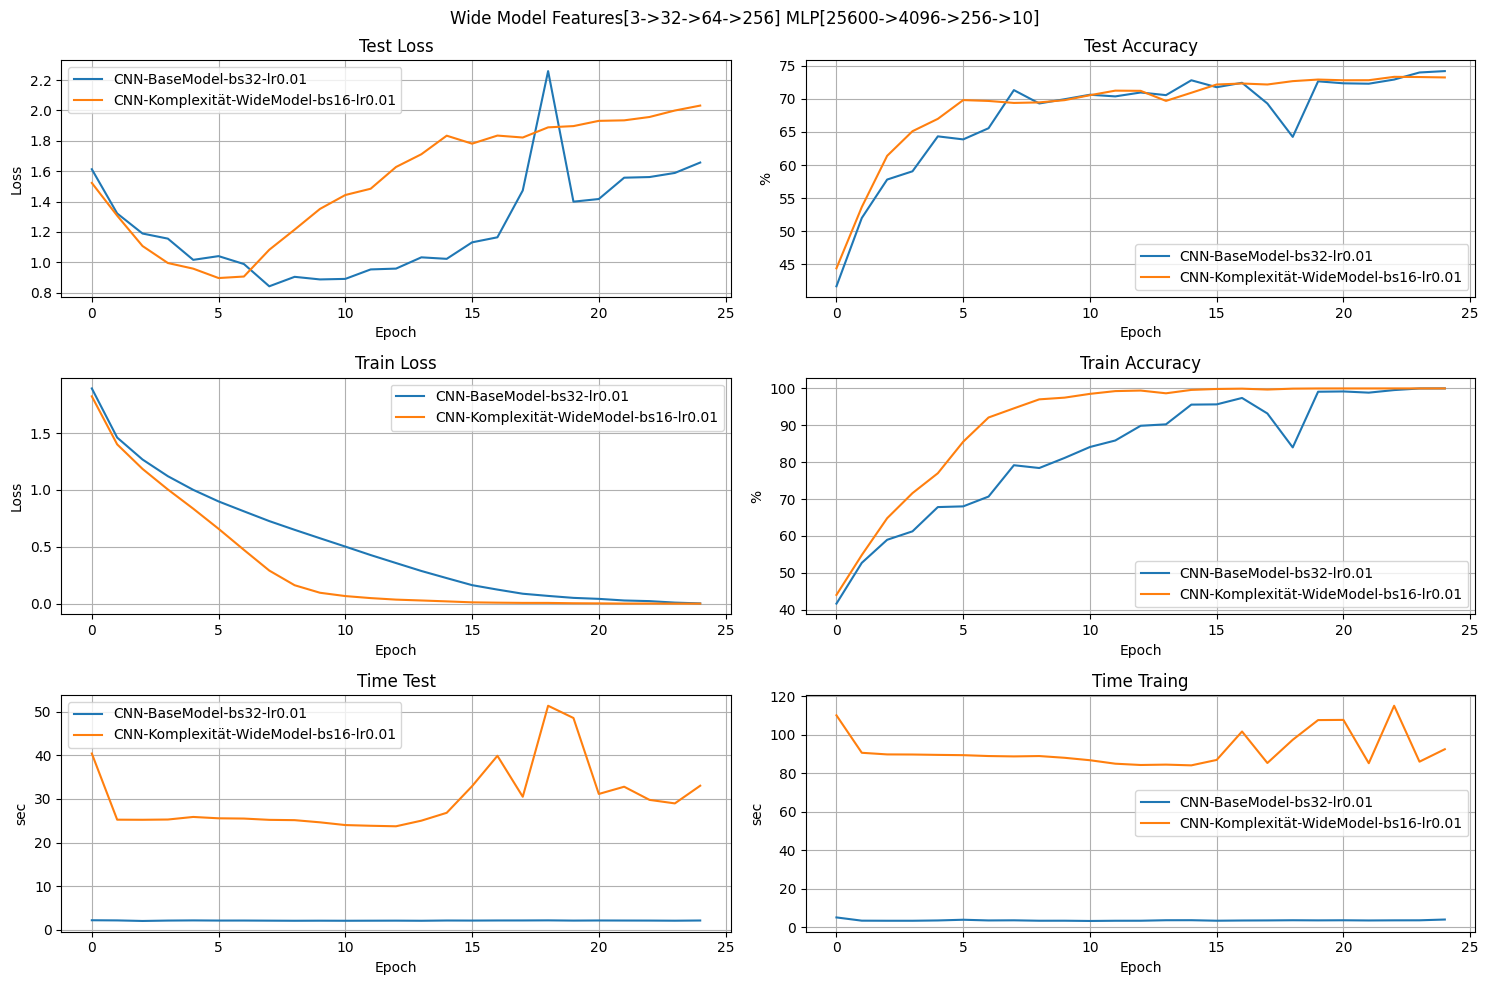

In [51]:
get_run_hist(['zrr3rl9x', 'ijhljvc1'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy', 'time_test', 'time_train'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy', 'Time Test', 'Time Traing'], 'Wide Model Features[3->32->64->256] MLP[25600->4096->256->10]')

###### Beobachtung
- Das Modell Overfittet bereits nach 6 Epochen
- Es ist  nicht viel besser als das Base-Modell

###### Interpretation
- Ein breiteres Modell bringt nicht unbedingt eine bessere Performance wobei es viel mehr Resourcen benötigt um zu trainieren
- Ein Modell mit nur mehr Feature-Channels lohnt sich nicht für diesen Datensatz
- Die leicht bessere Performance rechtfertigt die zusätzlich benötigten Resourcen nicht

#### Large but flat Model
Ich habe nun versucht ein Modell mit weniger Input-Features für die Fully-Connected Layer zu erstellen. Dazu habe ich die Anzahl der Feature-Channels in den Convolutional-Layern reduziert [3 -> 64 -> 64 -> 64].

In [52]:
class FlatModel(nn.Module):
    def __init__(self):
        super(FlatModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)  # 28*28*644
        self.conv2 = nn.Conv2d(64, 64, 5) # 24*24*64
        self.conv3 = nn.Conv2d(64, 64, 5) # 20*20*64
        self.pool1 = nn.MaxPool2d(2, 2) # 10*10*64
        self.fc1 = nn.Linear(6400, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [53]:
if run_models:
    flatModel = FlatModel()
    trained_model = test_model("FlatModel", 3, 3)

##### Analyse

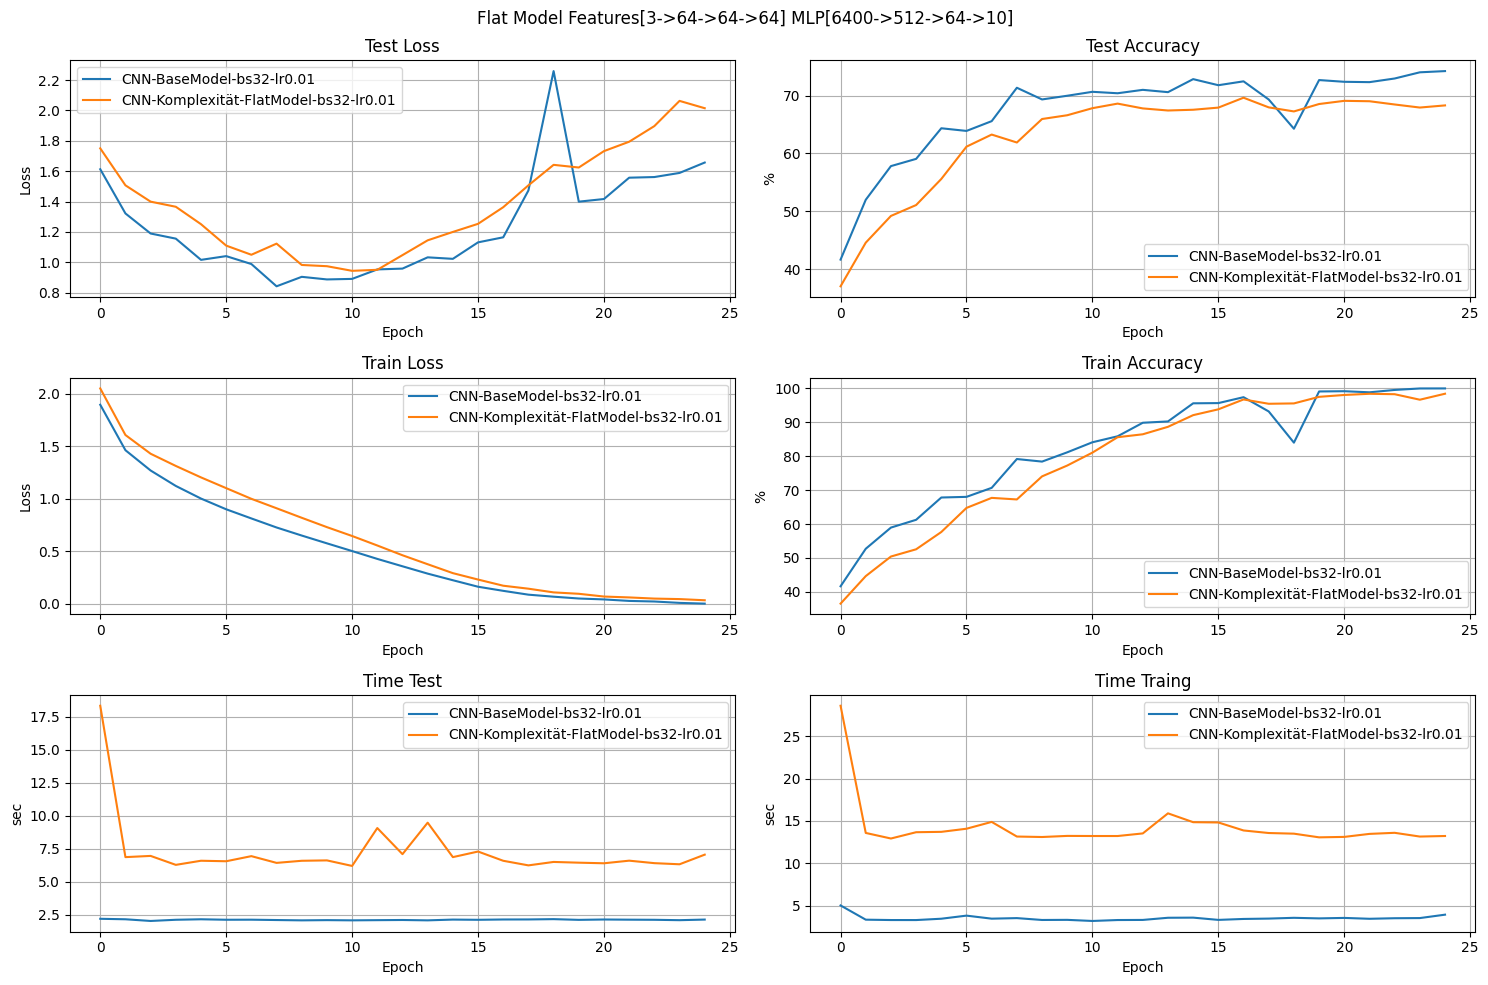

In [54]:
get_run_hist(['zrr3rl9x','yqebzl1a'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy', 'time_test', 'time_train'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy', 'Time Test', 'Time Traing'], 'Flat Model Features[3->64->64->64] MLP[6400->512->64->10]')

###### Beobachtung
- Das Modell overfittet langsamer als das Wide-Modell
- Es erreicht aber nicht die gleiche Accuracy wie das Wide-Modell
- Es braucht drei mal so lang pro Epoche wie das Base-Modell

###### Interpretation
- Durch weniger Feature-Channels gibt es auch weniger Input-Features für die Fully-Connected Layers
- Dieses Modell ist weniger geeignet als das Wide-Modell.


#### Deep CNN Model
Ich wollte ein wenig übertreiben und ganz viele Feature-Channels in den Convolutional-Layern haben. Dazu habe ich die Anzahl der Feature-Channels in den Convolutional-Layern drastisch erhöht [3 -> 64 -> 512 -> 1024]. Dadurch entstanden auch sehr viele Input-Features für die Fully-Connected Layer (102400). Durch Performancebeschrenkungen musste ich die Anzahl aber sehr schnell kürzen FCL: [102400 -> 128 -> 32 -> 10].

In [55]:
class DeepCNNModel(nn.Module):
    def __init__(self):
        super(DeepCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)  # 28*28*644
        self.conv2 = nn.Conv2d(64, 512, 5)  # 24*24*512
        self.conv3 = nn.Conv2d(512, 1024, 5)  # 20*20*1024
        self.pool1 = nn.MaxPool2d(2, 2)  # 10*10*1024
        self.fc1 = nn.Linear(102400, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [56]:
if run_models:
    trained_model = test_model("DeepCNNModel", 3, 3)

##### Analyse

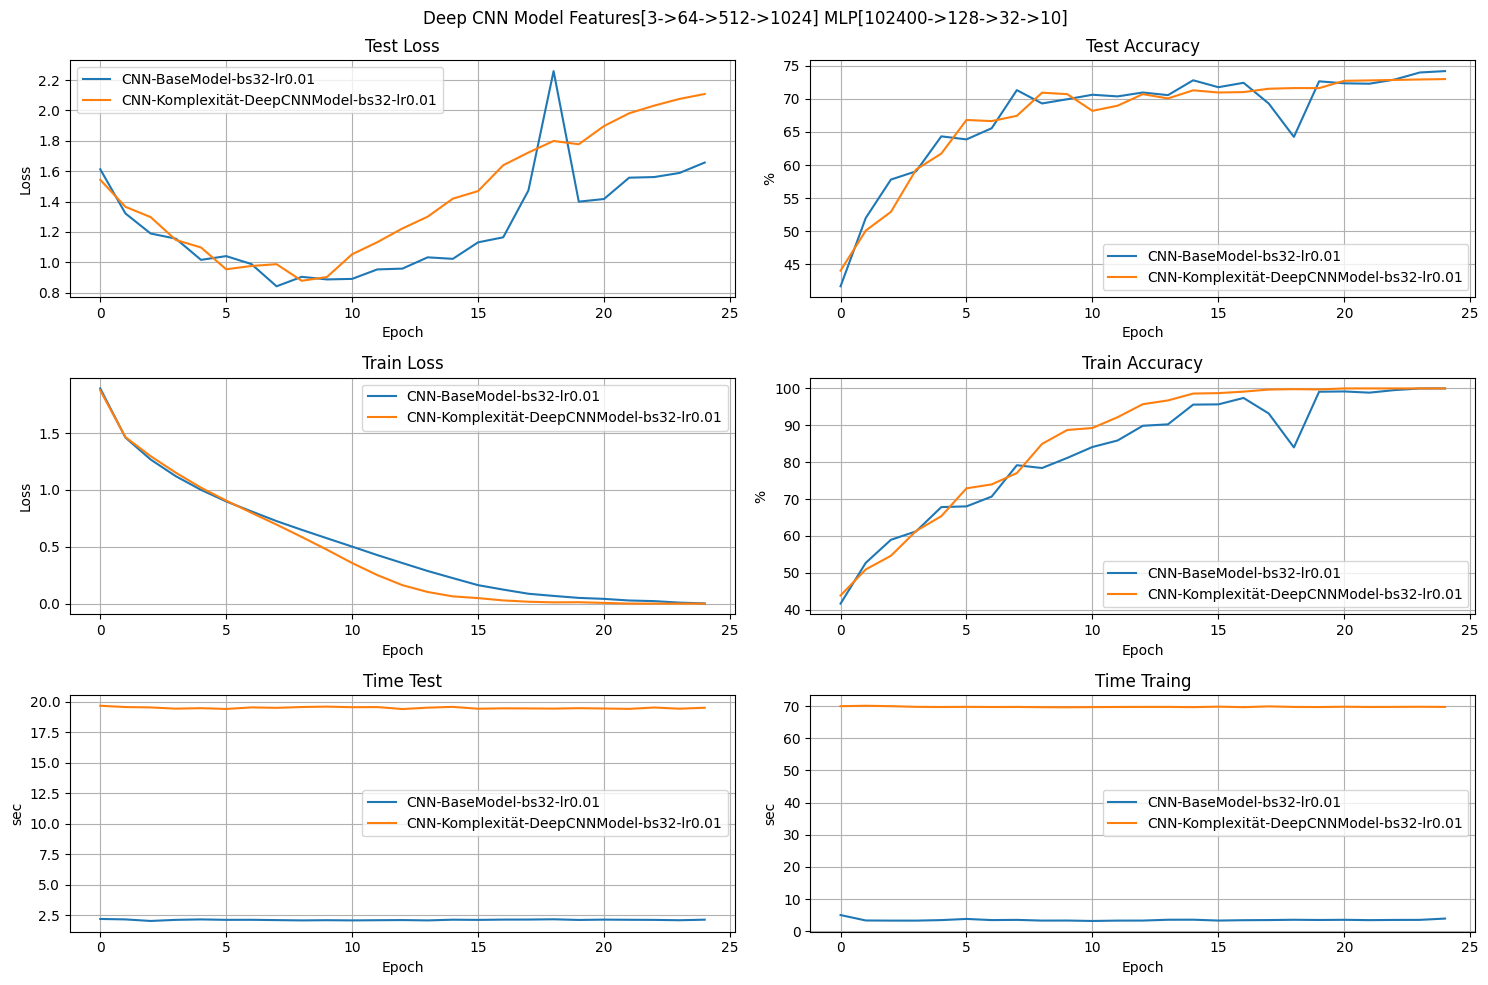

In [57]:
get_run_hist(['zrr3rl9x','ua0cp0n8'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy', 'time_test', 'time_train'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy', 'Time Test', 'Time Traing'], 'Deep CNN Model Features[3->64->512->1024] MLP[102400->128->32->10]')

###### Beobachtung
- Wie zu erwarten war, ist die Performance des Modells nicht deutlich anders als bei den beiden vorherigen
- Es Overfittet nach etwa 9 Epochen
- Die Accuracy liegt wieder um die 70%

###### Interpretation
- Die imensen Rechenresourcen konnten das Modell nicht verbessern
- Ein Modell mit so vielen Feature-Channels ist für diesen Datensatz nicht geeignet 


#### Many CNN-Layer Model
Ich habe das Trainieren der Modelle auf das SLURM-Cluster der Informatik ausgelagert. Ich kann ab jetzt deutlich grössere und komplexere Modelle trainieren.
Mit diesem Modell wollte ich ernuet testen ob mehr Convolutional-Layer einen Einfluss auf die Performance haben. Dazu habe ich die Anzahl der Convolutional-Layer auf 6 erhöht [3 -> 32 -> 128 -> 256 -> 512 -> 1024 -> 2048]. 
Durch die bessere Performance auf dem SLURM-Cluster kann ich jetzt auch grössere Fully-Connected Layer trainieren [204800 -> 256 -> 64 -> 10].

In [58]:
class ManyCNNModel(nn.Module):
    def __init__(self):
        super(ManyCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)  # 30*30*32
        self.conv2 = nn.Conv2d(32, 128, 3)  # 28*28*128
        self.conv3 = nn.Conv2d(128, 256, 3)  # 26*26*256
        self.conv4 = nn.Conv2d(256, 512, 3) # 24*24*512
        self.conv5 = nn.Conv2d(512, 1024, 3) # 22*22*1024
        self.conv6 = nn.Conv2d(1024, 2048, 3) # 20*20*2048
        self.pool1 = nn.MaxPool2d(2, 2)  # 10*10*2048
        self.fc1 = nn.Linear(204800, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

##### Analyse

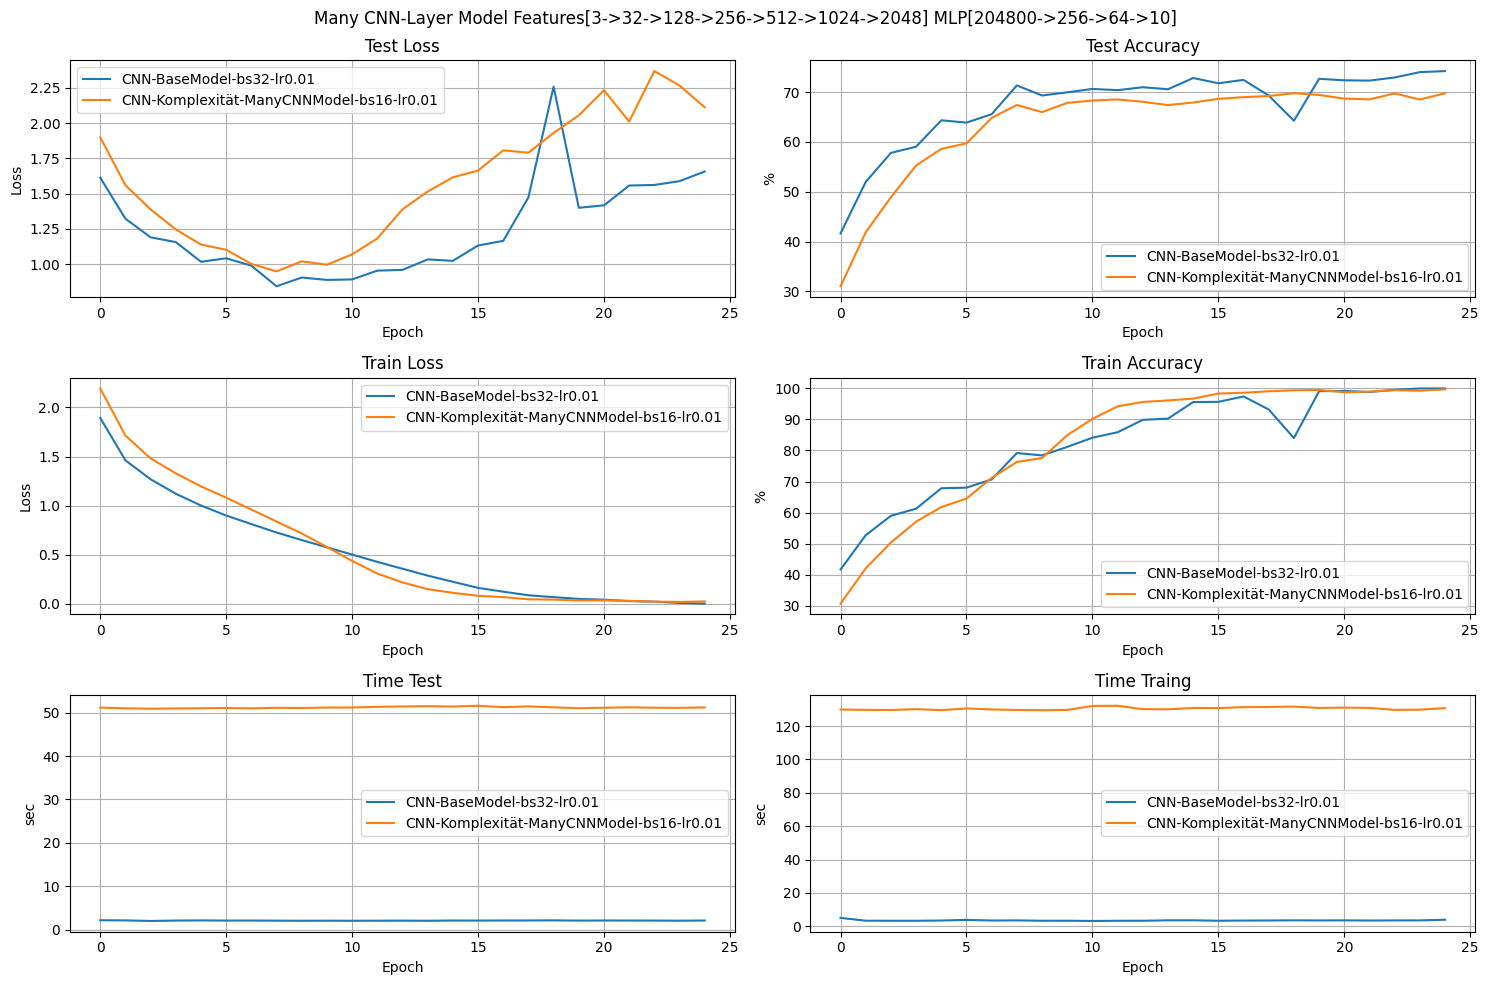

In [59]:
get_run_hist(['zrr3rl9x','el34h0dv'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy', 'time_test', 'time_train'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy', 'Time Test', 'Time Traing'], 'Many CNN-Layer Model Features[3->32->128->256->512->1024->2048] MLP[204800->256->64->10]')

###### Beobachtung
- Das Modell Overfittet nach etwa 9 Epochen
- Die Performance gleich wie beim Base-Modell
- Das Training ist sehr langsam

###### Interpretation
- Auch das Modell mit mehr Convolutional-Layern und breiteren Fully-Connected Layern bringt keine Verbesserung


#### MoreLinearCNNModel
Ich habe versucht die Anzahl der Fully-Connected Layer zu erhöhen. Dazu habe ich die Anzahl der Fully-Connected Layer auf 5 erhöht FCL: [73728 -> 512 -> 256 -> 128 -> 64 -> 10]. Ebenfalls habe ich die Anzahl der Convolutional-Layer auf 4 belassen [3 -> 32 -> 128 -> 256 -> 512].

In [60]:
class MoreLinearCNNModel(nn.Module):
    def __init__(self):
        super(MoreLinearCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)  # 30*30*32
        self.conv2 = nn.Conv2d(32, 128, 3)  # 28*28*128
        self.conv3 = nn.Conv2d(128, 256, 3)  # 26*26*256
        self.conv4 = nn.Conv2d(256, 512, 3) # 24*24*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 12*12*512
        self.fc1 = nn.Linear(73728, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

##### Analyse

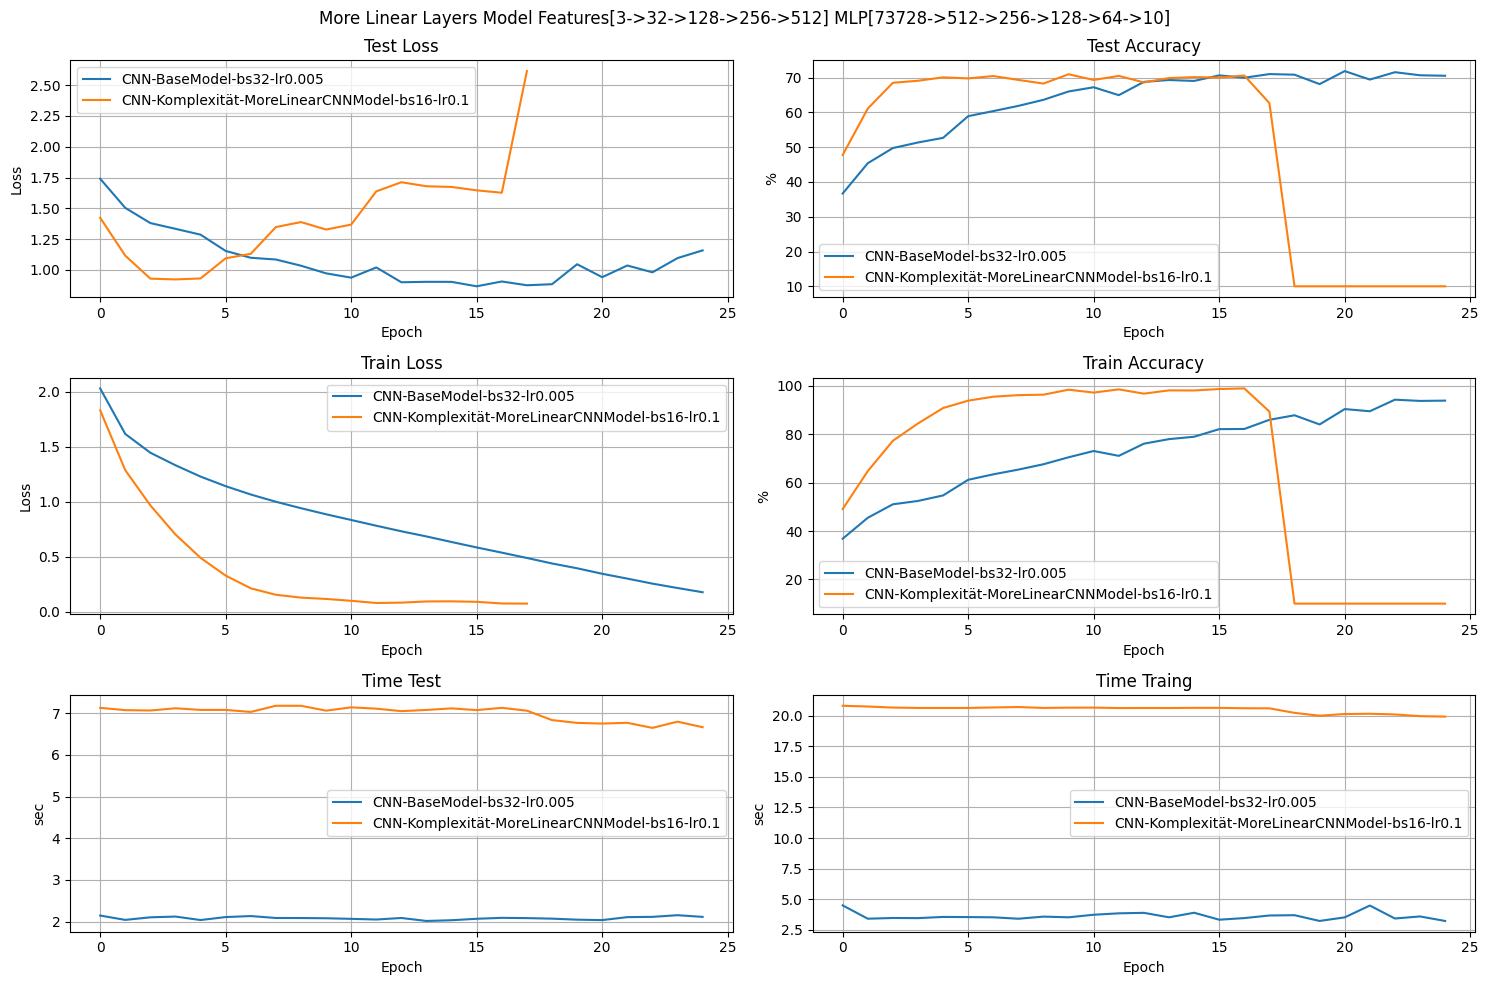

In [61]:
get_run_hist(['kv01pv41','81yzzyc4'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy', 'time_test', 'time_train'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy', 'Time Test', 'Time Traing'], 'More Linear Layers Model Features[3->32->128->256->512] MLP[73728->512->256->128->64->10]')

###### Beobachtung
- Ab Epoche 4 Overfittet das Modell
- Bei Epoche 16 "explodiert" der Loss. Der Loss ist NULL
- Der benötigte Zeitaufwand fürs Training ist deutlich geringer

###### Interpretation
- Das Modell ist wie alle anderen zuvor nicht signifikant besser als das Base-Modell
- In allen weiteren Experimenten werde ich diese Struktur als Grundlage nehmen, da es ein komplexes Modell ist welches aber nicht sonderlich schnell overfittet 
- Es ist schneller im Training als alle anderen Modelle vorher(mit Ausnahme Large but flat Model) jedoch immernoch viel langsamer als das Base-Modell 
- 


## Tuning der Convolutional Parameter

### Padding
Mit Padding fügt zusätzliche Pixel um das Bild herum hinzu. Dies kann helfen, die Grösse des Bildes zu erhalten und somit die Informationen am Rand des Bildes nicht zu vernachlässigen.

In [62]:
class TuningConvCNNModel(nn.Module):
    def __init__(self):
        super(TuningConvCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # 32*32*32
        self.conv2 = nn.Conv2d(32, 128, 3, padding=1)  # 32*32*128
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # 32*32*256
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1) # 32*32*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 16*16*512
        self.fc1 = nn.Linear(131072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [63]:
class TuningConvCNNModel(nn.Module):
    def __init__(self):
        super(TuningConvCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2)  # 34*34*32
        self.conv2 = nn.Conv2d(32, 128, 3, padding=2)  # 36*36*128
        self.conv3 = nn.Conv2d(128, 256, 3, padding=2)  # 38*38*256
        self.conv4 = nn.Conv2d(256, 512, 3, padding=2) # 40*40*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 18*18*512
        self.fc1 = nn.Linear(204800, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

##### Analyse

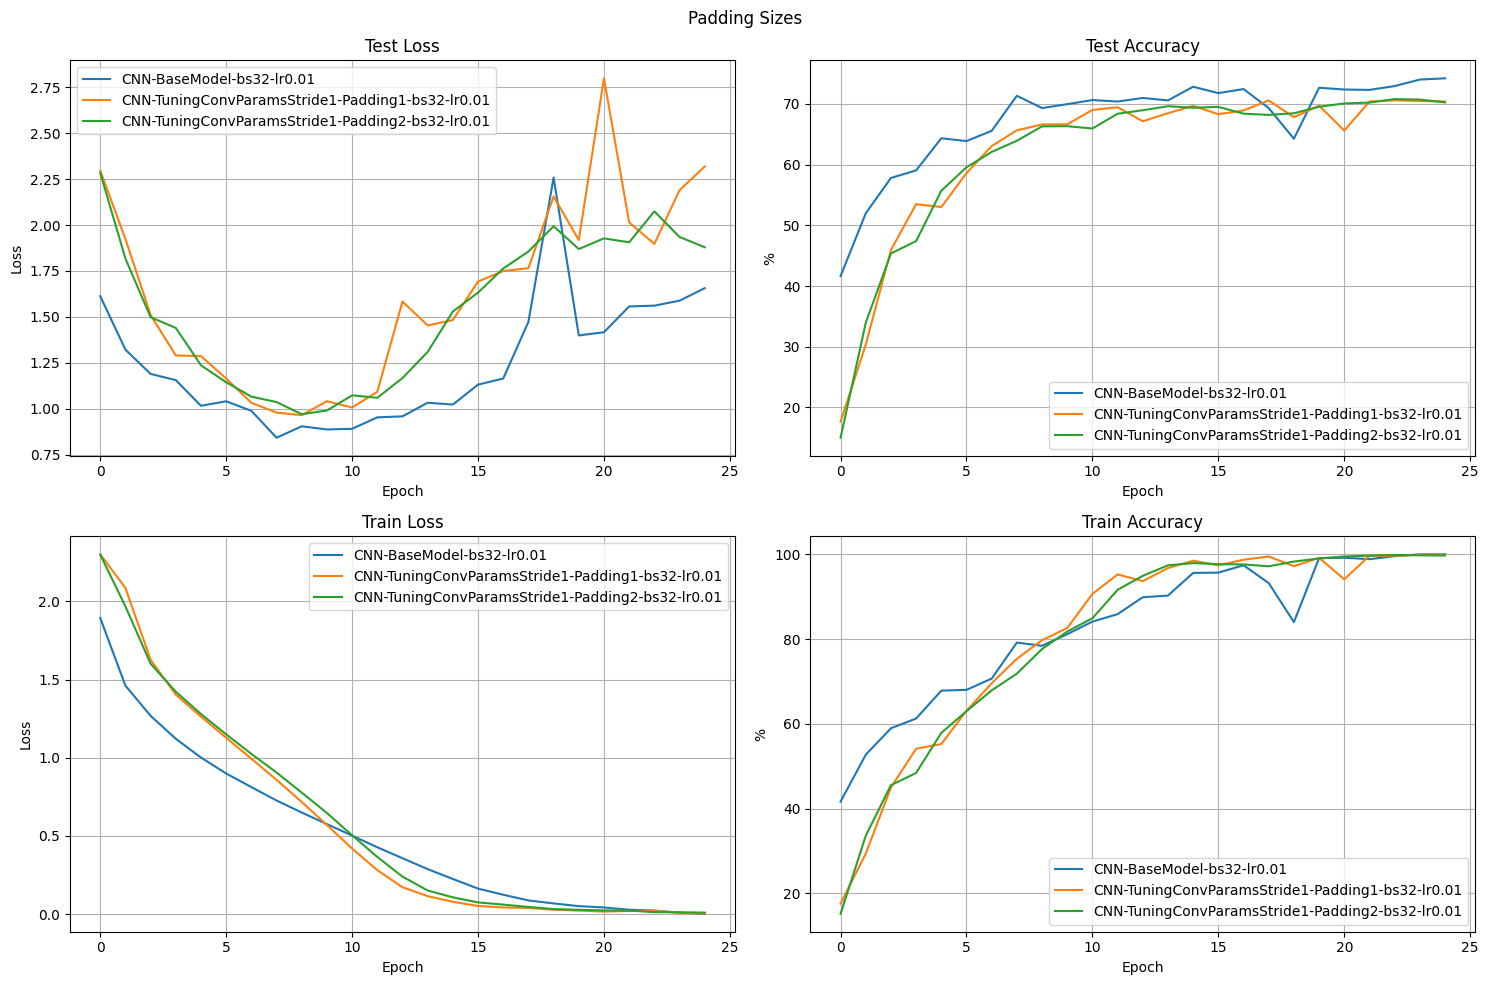

In [64]:
get_run_hist(['zrr3rl9x', '2b1zqlvc', '9g14udlm'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Padding Sizes')

###### Beobachtung
- Beide Modelle mit padding schneiden schlechter ab als das Base-Modell
- Die beiden Modelle sind sehr ähnlich

###### Interpretation
- Eventuell war die Learning Rate für die Modelle zu hoch, da sie mehr Input-Features generieren

### Stride
Stride bestimmt wie viele Pixel das Filter pro Schritt verschiebt. Ein grösserer Stride reduziert die Grösse des Bildes.

**Bemerkung:** Da die Bilder des Cifar-10 Datensatzes 32x32 Pixel gross sind, kann der Stride nicht so gross sein, dass die Bilder sonst kleiner als 1x1 Pixel werden.
Aus dem selben Grund habe ich auch den Pooling Layer entfernt.

In [65]:
class TuningConvCNNModel(nn.Module):
    def __init__(self):
        super(TuningConvCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0)  # 15*15*32
        self.conv2 = nn.Conv2d(32, 128, 3, stride=2, padding=0)  # 7*7*128
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=0)  # 3*3*256
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=0) # 1*1*512
        #self.pool1 = nn.MaxPool2d(2, 2)  # 1*1*512
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        #x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

### Padding & Stride

In [66]:
class TuningConvCNNModel(nn.Module):
    def __init__(self):
        super(TuningConvCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=2)  # 17*17*32
        self.conv2 = nn.Conv2d(32, 128, 3, stride=2, padding=2)  # 10*10*128
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=2)  # 6*6*256
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=2) # 4*4*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 2*2*512
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [67]:
class TuningConvCNNModel(nn.Module):
    def __init__(self):
        super(TuningConvCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=3)  # 18*18*32
        self.conv2 = nn.Conv2d(32, 128, 3, stride=2, padding=3)  # 11*11*128
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=3)  # 8*8*256
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=3) # 6*6*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 3*3*512
        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

##### Analyse

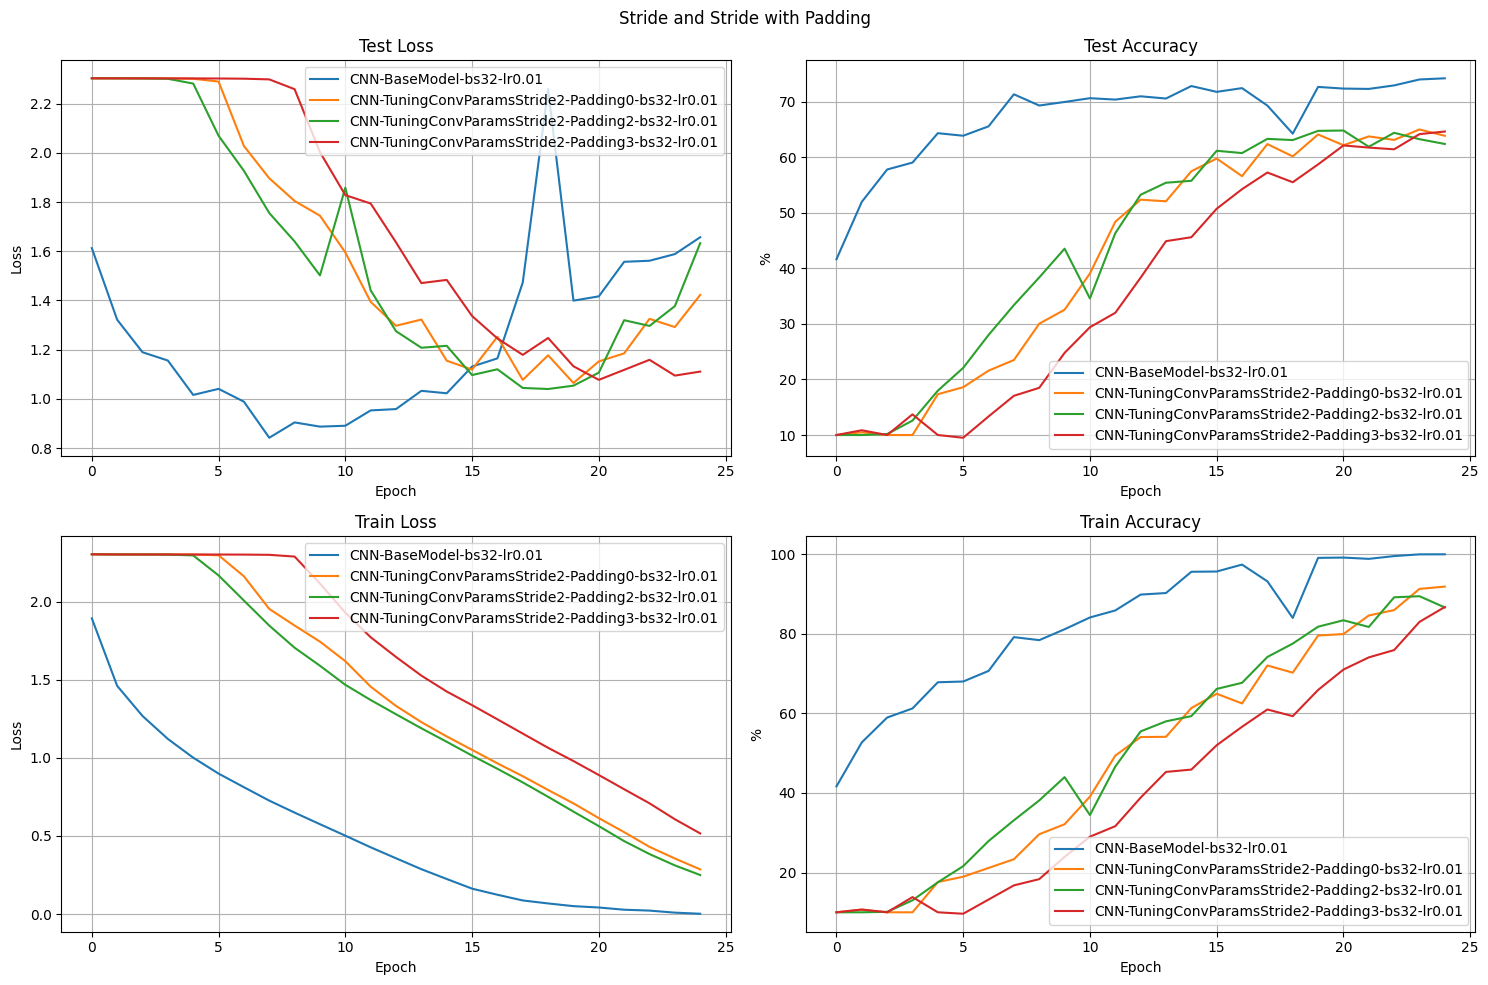

In [68]:
get_run_hist(['zrr3rl9x', 'neastfw3', 'wbdgh7pv', 'myp1j24a'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Stride and Stride with Padding')

###### Beobachtung
- Alle Modelle mit Stride > 1 konvergieren in den ersten paar Epochen nicht
- Ebenfalls schneiden sie schlechter ab als das Base-Modell


###### Interpretation
Ich denke das die Bilder durch die Stride zu klein werden und zu viel Information verloren geht, welche mit dem padding nicht ausgeglichen werden kann. 
Ebenfalls sind die Bilder mit 32x32 Pixeln sehr klein.

### Kernel Size
Beschreibt die Grösse der Filter welche über die Bilder geschoben werden. Ein grösserer Filter kann mehr Informationen aufnehmen, verringert die Grösse des Bildes jedoch stärker.

In [69]:
class TuningConvCNNModel(nn.Module):
    def __init__(self):
        super(TuningConvCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=0)  # 28*28*32
        self.conv2 = nn.Conv2d(32, 128, 5, stride=1, padding=0)  # 24*24*128
        self.conv3 = nn.Conv2d(128, 256, 5, stride=1, padding=0)  # 20*20*256
        self.conv4 = nn.Conv2d(256, 512, 5, stride=1, padding=0) # 16*16*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 8*8*512
        self.fc1 = nn.Linear(32768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [70]:
class TuningConvCNNModel(nn.Module):
    def __init__(self):
        super(TuningConvCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)  # 30*30*32
        self.conv2 = nn.Conv2d(32, 128, 3, stride=1, padding=0)  # 28*28*128
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=0)  # 26*26*256
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=0) # 24*24*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 12*12*512
        self.fc1 = nn.Linear(73728, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

##### Analyse

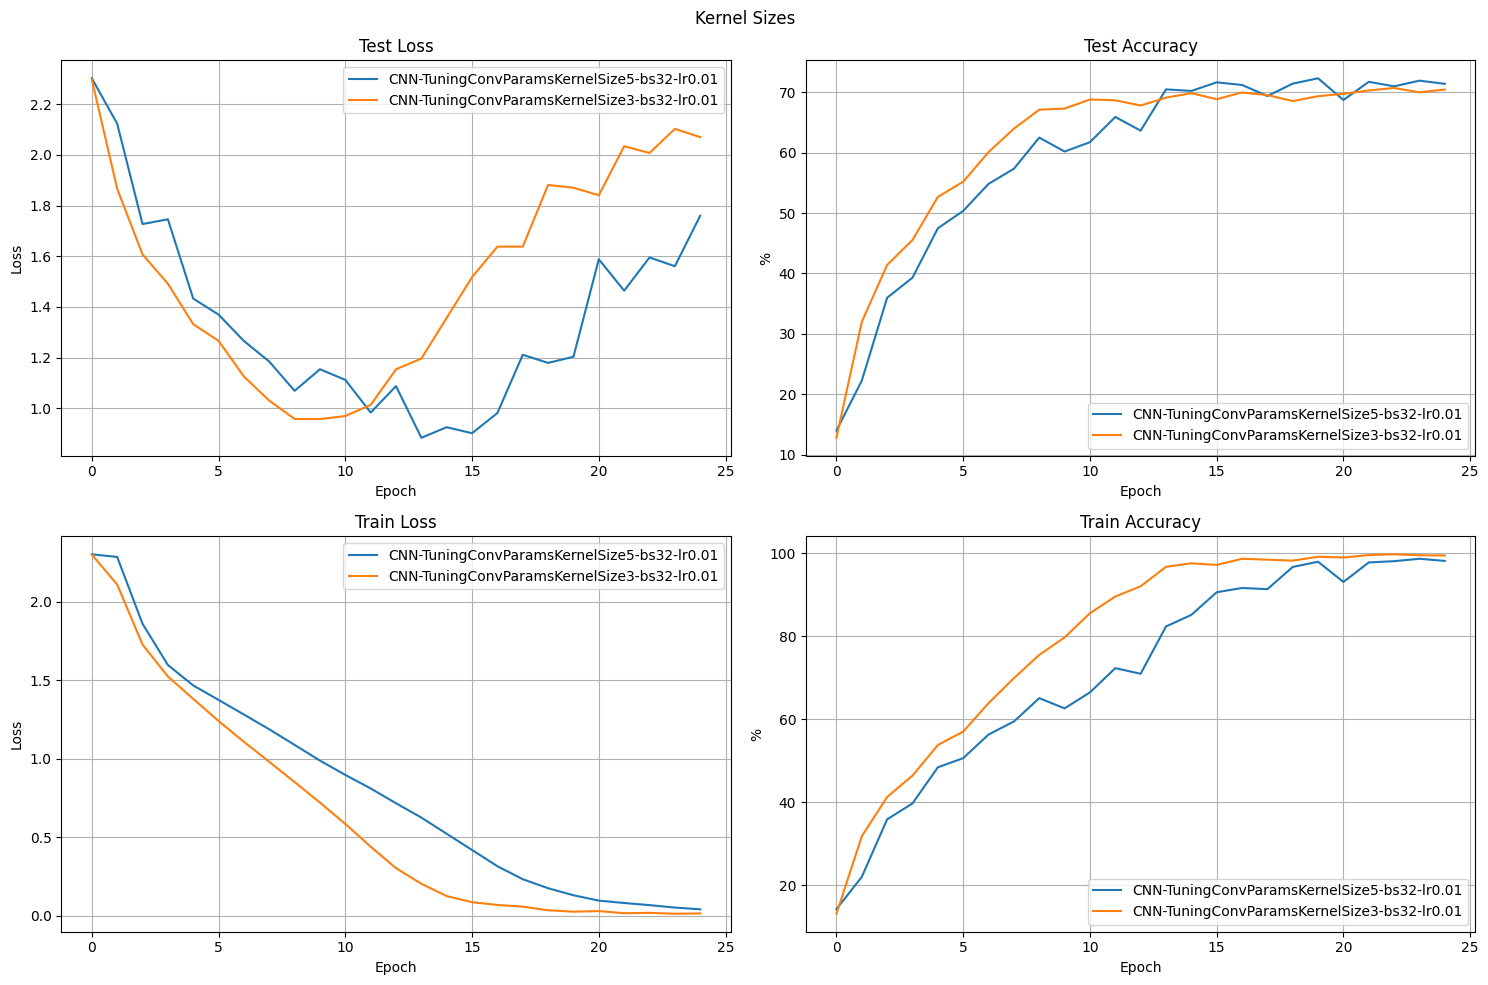

In [71]:
get_run_hist(['j21ejguw', 'ws6jz2ay'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Kernel Sizes')

###### Beobachtung
- Der kleinere Kernel overfittet schneller
- Beide Modelle scheinen ähnlich zum Base-Modell zu sein


###### Interpretation
Ein grösserer Kernel scheint auf diesen Bildern nicht unbedingt besser zu sein.




## Regularisierung
### Ziel von Regularisierung
Regularisierung in CNNs dient dazu, Overfitting zu verhindern und das Modell allgemein zu halten. Dies kann entweder durch das verändern der Gewichte des Modells oder durch das verändern der Trainingsdaten erreicht werden.

### L1 Weight Penalty
Um die Weight Penalty zu implementieren, muss die train-Funktion angepasst werden.
Nachfolgend sind die neuen Trainfunktionen für die L1 und L2 Penalty.

Die L1-Regularisierung fügt einen Strafterm zur Loss-Funktion hinzu, welcher die Summe der absoluten Werte der Gewichte ist.
Dieser zusätzliche Term bestraft grosse Gewichte und zwingt das Modell dazu, nur die wichtigsten Features zu verwenden.
Die Stärke der Bestrafung wird durch den Hyperparameter Lambda bestimmt.

In [72]:
def train(self, train_loader,test_loader, num_epochs, lambda_l1=0.01):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            start_traintime = time.time()
            self.model.train()
            for i, (data) in enumerate(train_loader, 0):
                inputs, labels = data
                
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                
                loss = self.criterion(outputs, labels)
                
                l1_penalty = 0
                for parameter in self.model.parameters():
                    l1_penalty += torch.sum(torch.abs(parameter))
                    
                loss = loss + (lambda_l1 * l1_penalty)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / (i+1)
            endtime_train = time.time() - start_traintime
            test_accuracy, train_accuracy, train_loss, test_loss = self.evaluate(test_loader=test_loader, train_loader=train_loader, train_loss=train_loss, endtime_train=endtime_train)
            print(f"Epoch {epoch+1}, Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
        print("Finished Training")
        wandb.finish()
        return self.model

##### Analyse

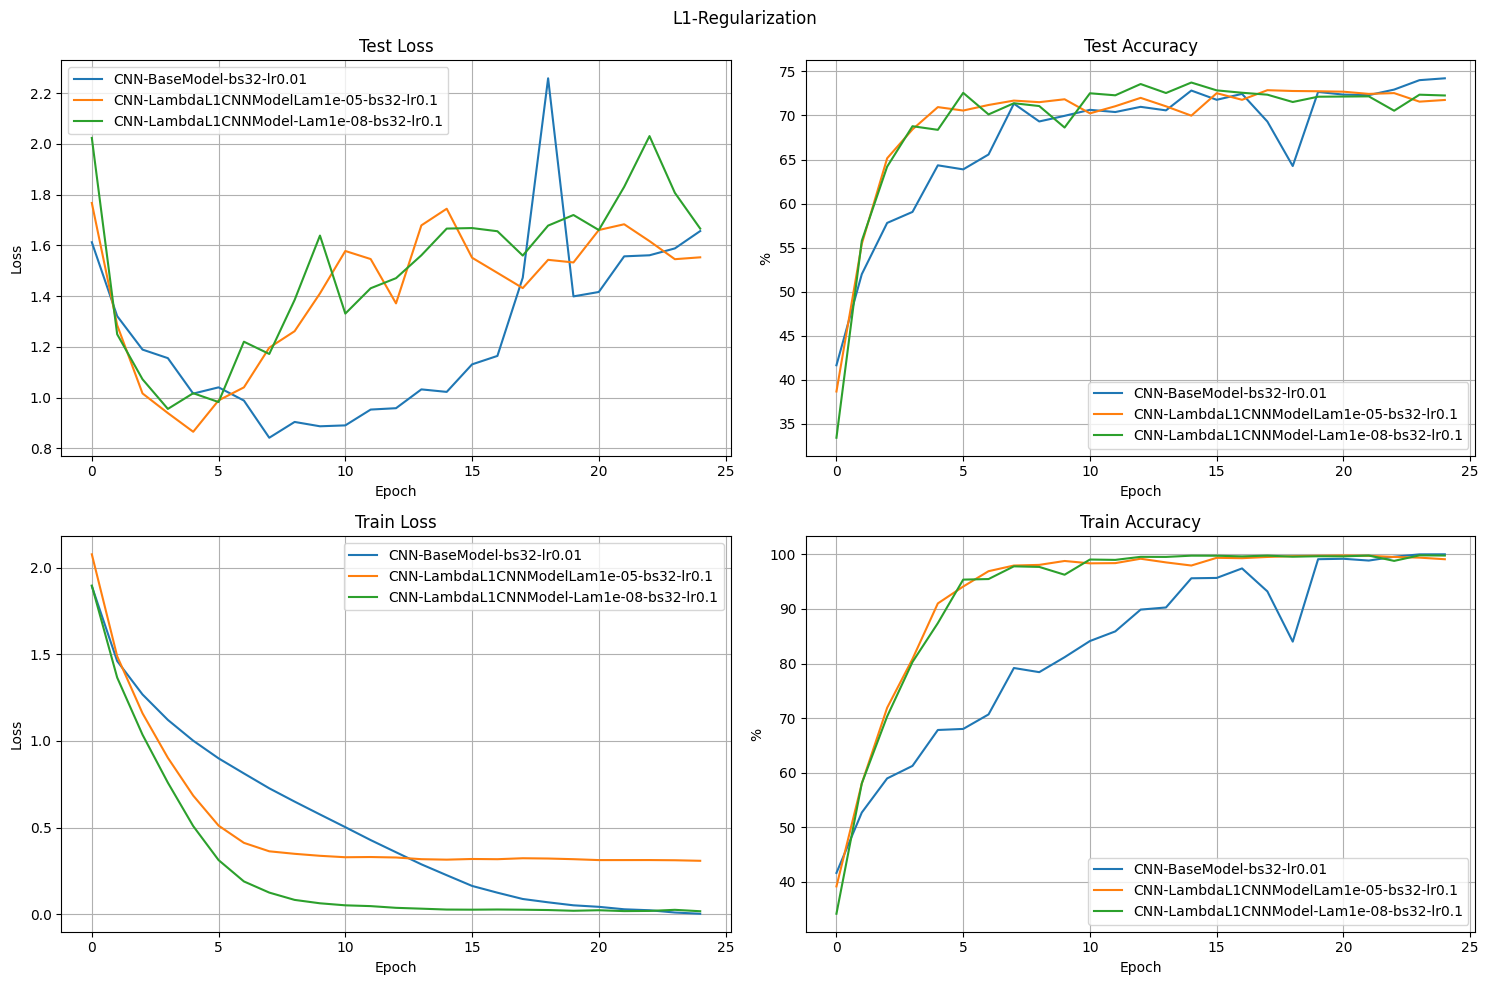

In [73]:
get_run_hist(['zrr3rl9x','pixkcts9', 'xk1okk11'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'L1-Regularization')

###### Beobachtung
- Der Train-Loss stagniert bei den Modellen mit Regularisierung
- Die Modelle mit Regularisierung Overfitten trotzdem

###### Interpretation
- Ich kann nicht nachvollziehen wieso die Modelle mit Regularisierung schneller overfitten als das Base-Model.
- Die Ergebnisse sind aber allgemein nicht schlecht

### L2 Weight Penalty
Die L2-Regularisierung ist der L1-Regularisierung sehr ähnlich. Sie fügt ebenfalls einen Strafterm zur Loss-Funktion hinzu, jedoch die Summe der Quadrate der Gewichte.
Die Gewichte werden dadurch bestraft wenn diese gross sind, fallen aber nicht bis auf Null. Dadurch wird das Modell flacher und die Gewichte werden kleiner.

In [74]:
def train(self, train_loader,test_loader, num_epochs, lambda_l2=0.01):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            start_traintime = time.time()
            self.model.train()
            for i, (data) in enumerate(train_loader, 0):
                inputs, labels = data
                
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                
                loss = self.criterion(outputs, labels)
                
                l2_penalty = 0
                for parameter in self.model.parameters():
                    l2_penalty += torch.sum(parameter ** 2)
                    
                loss = loss + (lambda_l2 * l2_penalty)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / (i+1)
            endtime_train = time.time() - start_traintime
            test_accuracy, train_accuracy, train_loss, test_loss = self.evaluate(test_loader=test_loader, train_loader=train_loader, train_loss=train_loss, endtime_train=endtime_train)
            print(f"Epoch {epoch+1}, Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
        print("Finished Training")
        wandb.finish()
        return self.model

##### Analyse

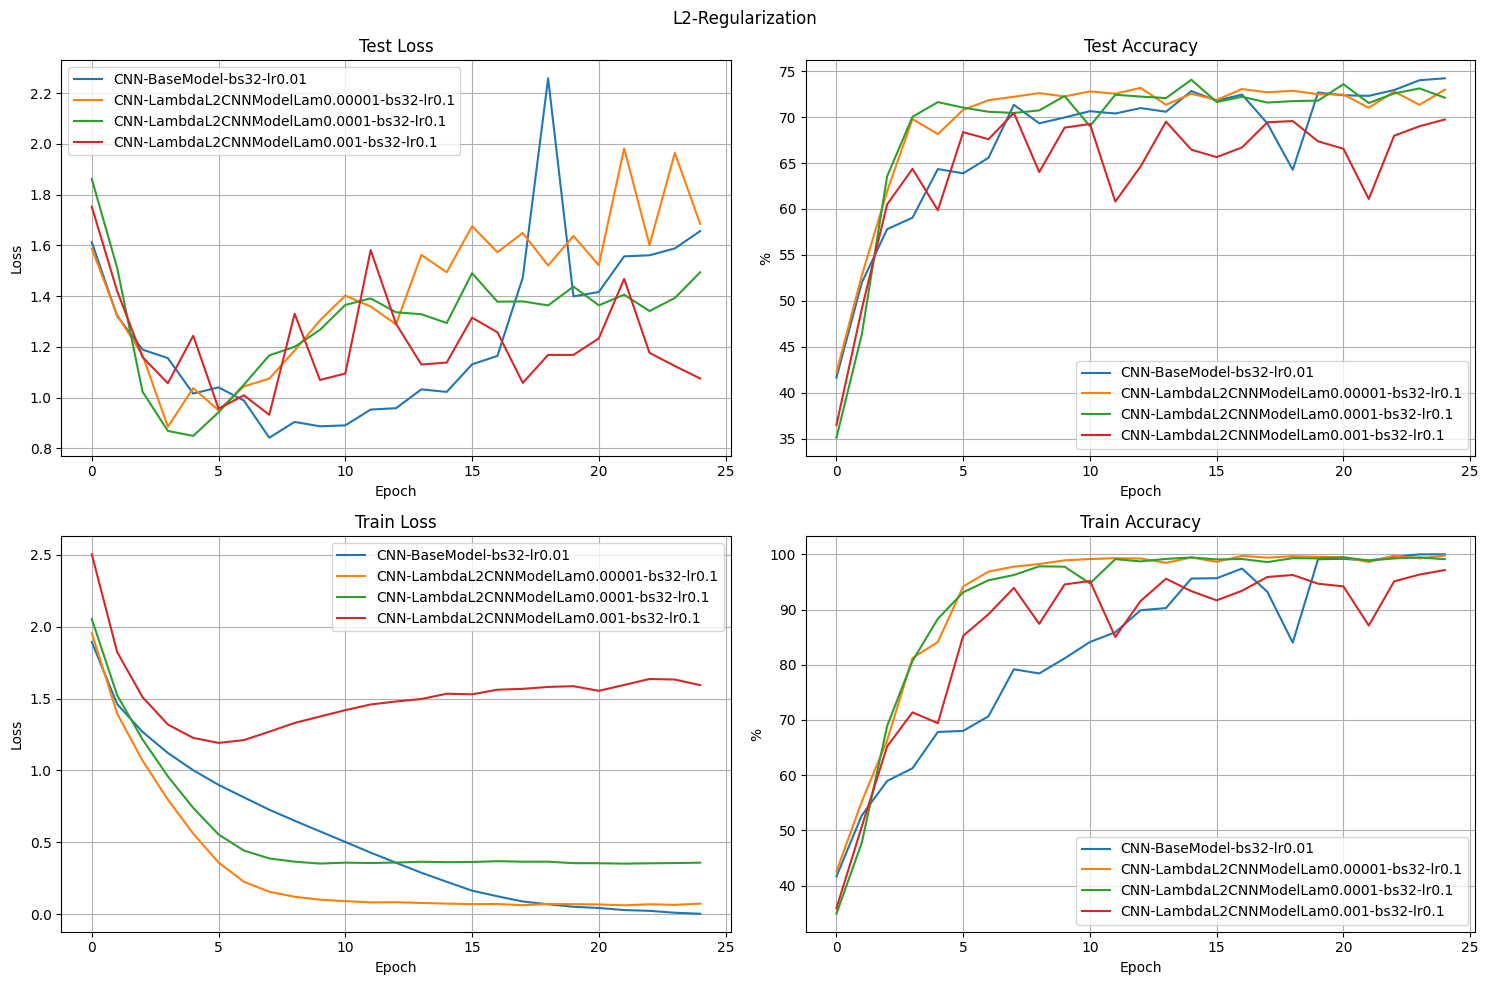

In [75]:
get_run_hist(['zrr3rl9x', 'gxxae9a0', 'i9znf9oo', 'mw9aqljn'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'L2-Regularization')

###### Beobachtung
- Wie bei der L1-Regularisierung stagniert der Train-Loss bei den Modellen mit Regularisierung
- Beim Modell mit Lambda 0.001 steigt der Train-Loss wieder an
- Die Modelle mit Regularisierung Overfitten trotzdem

###### Interpretation
Ich habe das Gefühl das dass Modell zu komplex ist und die Regularisierung keinen grossen Einfluss auf das Overfitting hat.

### Dropout
Die Dropout-Regularisierung ist eine weitere Methode um Overfitting zu reduzieren. Dabei wird ein zufälliger Anteil der Neuronen in einem Layer während des Trainings deaktiviert. Dies zwingt das Modell dazu, nicht nur auf einzelne Neuronen zu vertrauen, sondern zu verallgemeinern. Ich habe eine Dropout-Rate von 0.3 gewählt. Das bedeutet, dass 30% der Neuronen in einem Layer deaktiviert werden.

In [76]:
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)  # 32*32*32
        self.conv2 = nn.Conv2d(32, 128, 5, stride=1, padding=2)  # 32*32*128
        self.conv3 = nn.Conv2d(128, 256, 5, stride=1, padding=2)  # 32*32*256
        self.conv4 = nn.Conv2d(256, 512, 5, stride=1, padding=2) # 32*32*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 16*16*512
        self.fc1 = nn.Linear(131072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

##### Analyse

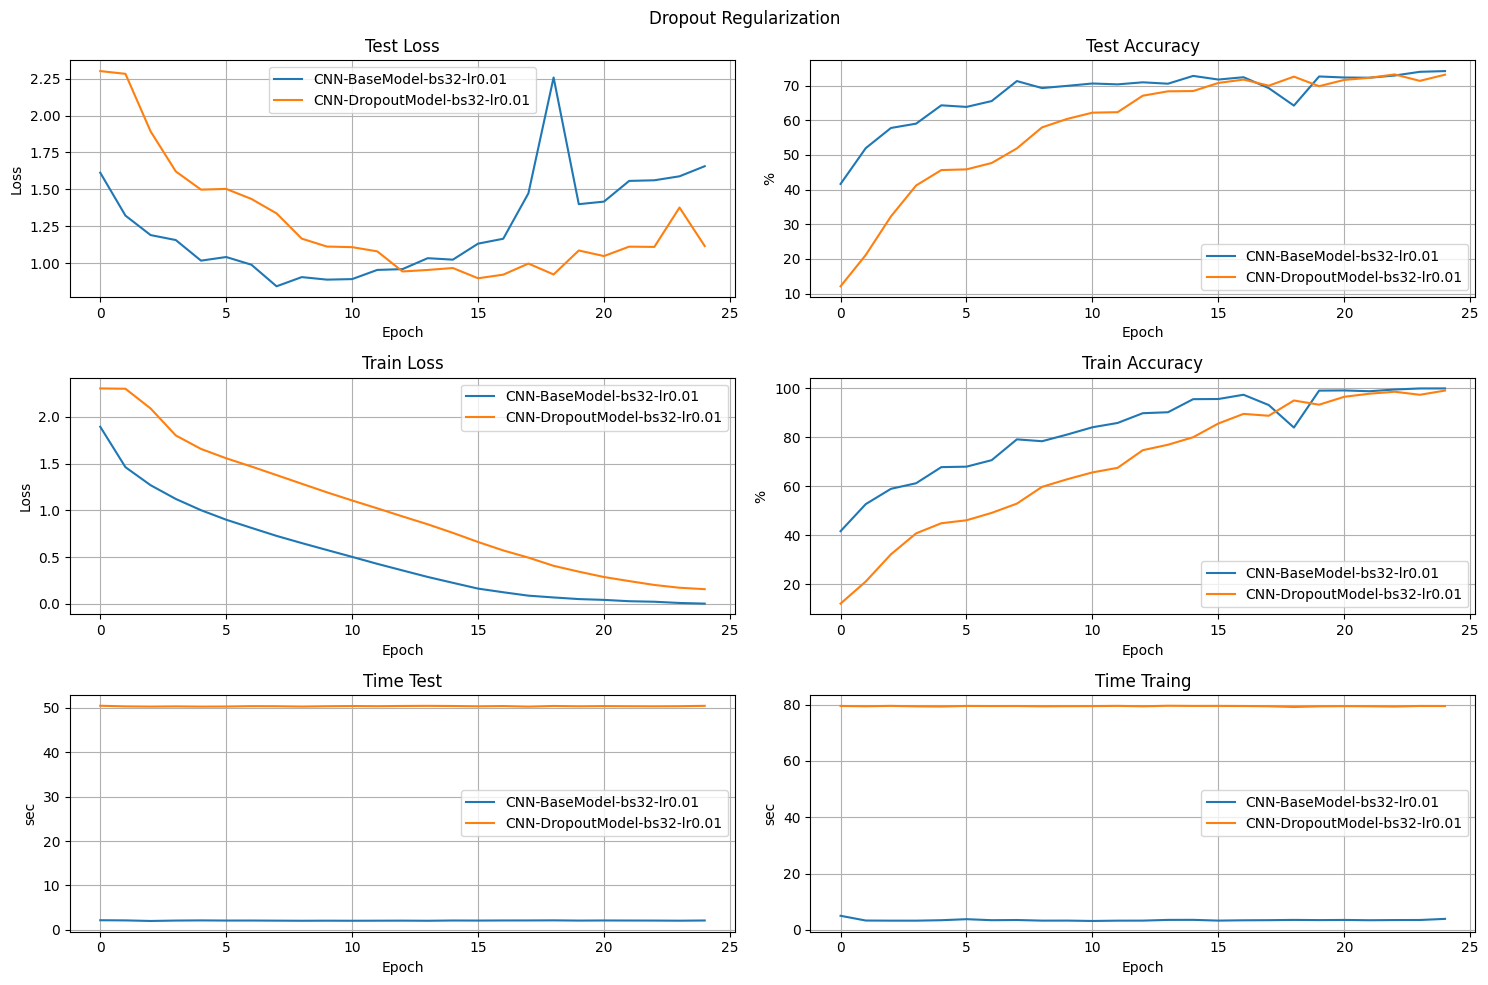

In [77]:
get_run_hist(['zrr3rl9x','z8p3p3o5'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy', 'time_test', 'time_train'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy', 'Time Test', 'Time Traing'], 'Dropout Regularization')

###### Beobachtung
- Das Modell mit Dropout overfittet später als das Base-Modell
- Die Performance ist gleich wie beim Base-Modell
- Das Training ist deutlich langsamer

###### Interpretation
Ich denke das Dropout die bisher beste Regularisierungsmethode ist. Es ist einfach zu implementieren und hat eine gute Wirkung ohne die Performance des Modells zu stark zu beeinflussen.



### Data-Augmentation
Um das Overfitting weiter einzudämmen, versuche ich nun durch Data-Augmentation Abwechslung in die Daten zu bringen.
Dies mache ich mit den transforms.-Operationen.

**Flips**
Horizontale oder vertikale Spiegelungen erweitern die verschiedenen möglichen Blickwinkel des Modells.

**Rotation**
Fast wie Flips, nur dass das Bild um einen zufälligen Winkel rotiert wird.

**RandomResizedCrop**
Es wird ein zufälliger Ausschnitt des Bildes genommen und auf die Grösse 32x32 Pixel skaliert.

**RandomErasing**
Ein zufälliger Teil des Bildes wird mit Nullen überschrieben. Dies soll das Modell robuster gegenüber fehlenden Teilen des Bildes machen.

Das ganze habe ich in ein RandomChoice-Transform gepackt, damit jedes Bild zufällig augmentiert wird aber nicht alles gleichzeitig und immer.

In [78]:
def prepare_data():
    
    transform = transforms.Compose([
        transforms.RandomChoice([
            transforms.RandomHorizontalFlip()
            , transforms.RandomRotation(45)
            , transforms.RandomVerticalFlip()
            , transforms.RandomResizedCrop(32, scale=(0.5, 1.0))
        ])
        ,   transforms.ToTensor()
        ,   transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=True)
        #, transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784), inplace=True) # Auskommentiert für die Visualisierung
    ])
    
    training_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transform
    )
    
    normal_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )
    
    train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True, prefetch_factor=2)
    
    normal_dataLoader = DataLoader(normal_data, batch_size=1, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True, prefetch_factor=2)
    
    return train_dataloader, normal_dataLoader

Files already downloaded and verified
Files already downloaded and verified


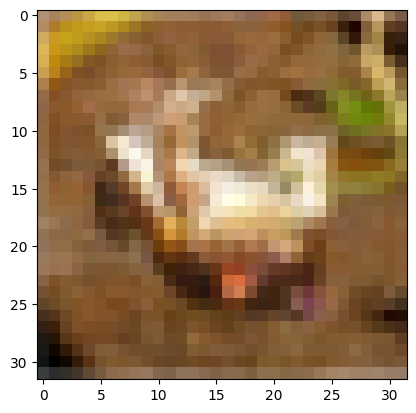

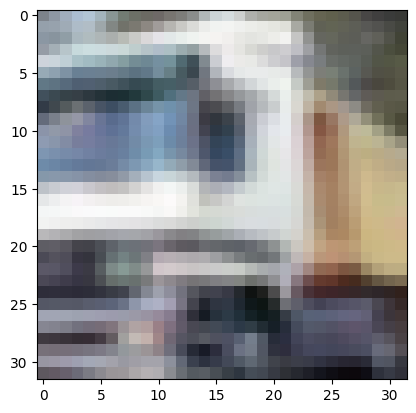

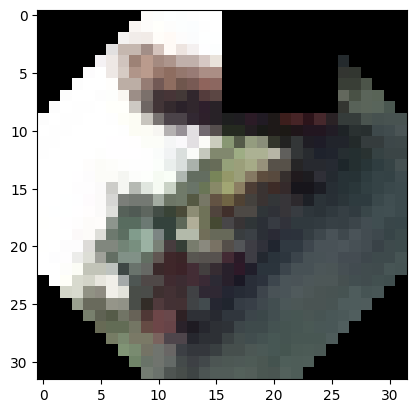

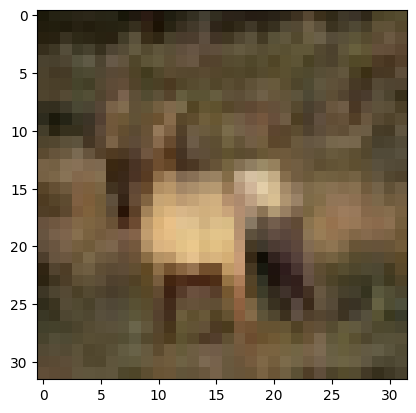

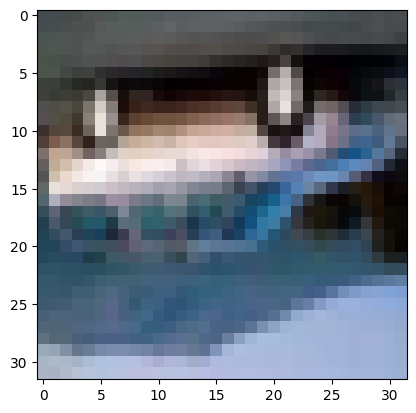

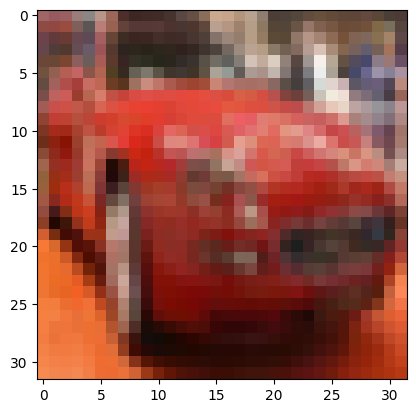

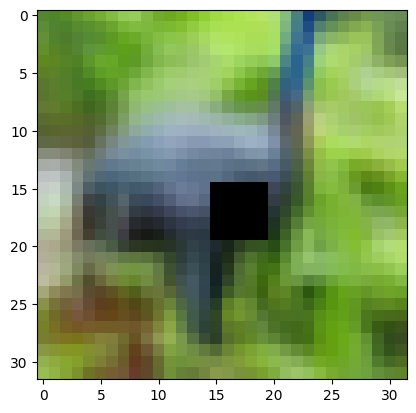

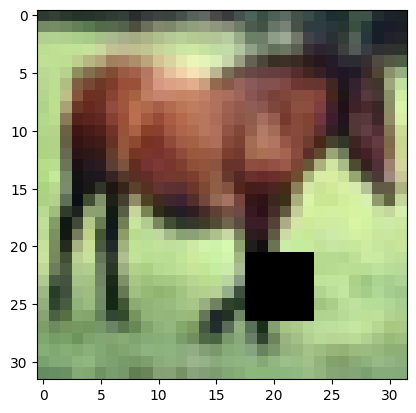

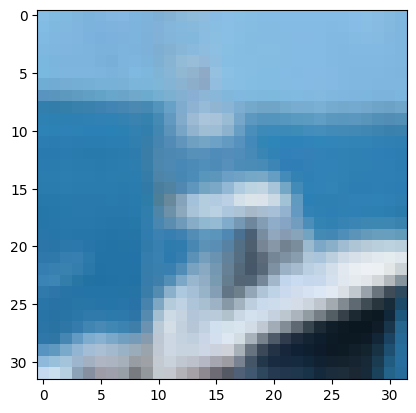

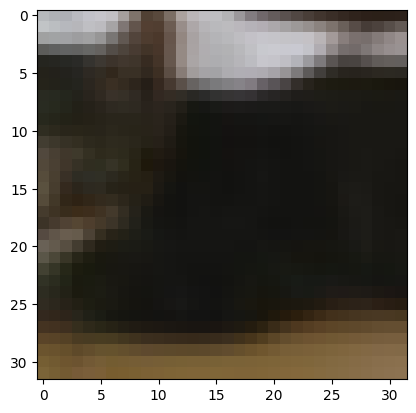

In [79]:
trainLoader, normalLoader = prepare_data()
# Orginalbilder daneben anzeigen
for i, data in enumerate(trainLoader, 0):
    if i == 10:
        break
    img = data[0][0].permute(1, 2, 0)
    plt.imshow(img)
    plt.show()


In [80]:
class AugmentationModel(nn.Module):
    def __init__(self):
        super(AugmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=2)  # 17*17*32
        self.conv2 = nn.Conv2d(32, 128, 3, stride=2, padding=2)  # 10*10*128
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=2)  # 6*6*256
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=2)  # 4*4*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 2*2*512
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

##### Analyse

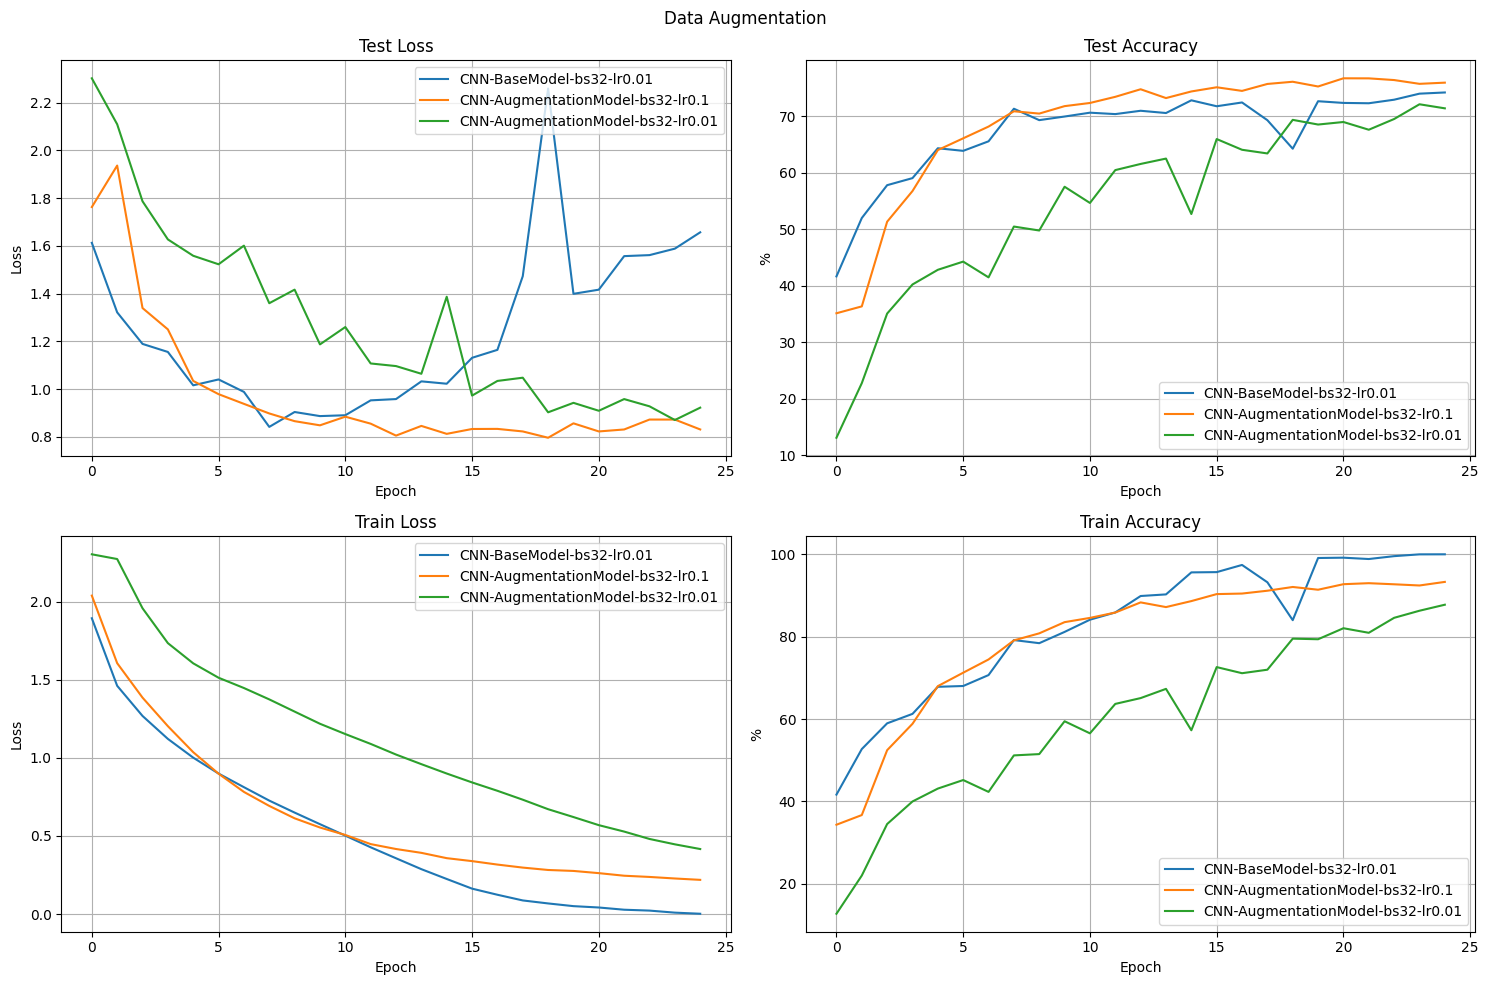

In [81]:
get_run_hist(['zrr3rl9x', '5kafojcl', 'sh0y8c6g'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'Data Augmentation')

###### Beobachtung
- Beide Modelle mit Data Augmentation overfitten in den ersten 25 Epochen nicht
- Das Modell mit Learning Rate 0.01 ist besser als das Base-Modell
- Das Modell mit Learning Rate 0.1 scheint so als würde es noch weiter konvergieren

###### Interpretation
Diese Methode scheint sehr gut zu funktionieren. Die Modelle overfitten später und die Performance ist besser als beim Base-Modell.
Ebenfalls ist diese Methode einfach zu implementieren. Man könnte noch weitere Transformationen hinzufügen sowie jeweils die Orginalbilder behalten. Dadurch hätte man deutlich mehr Trainingsdaten.



## Batch Normalization
Bei der Batch Normalisation wird ein zusätzlicher Berechnungsschritt zwischen einer Schicht und derer Aktivierungsfunktion eingefügt.
Die Daten werden normalisiert. Während des Trainings mit dem Mittelwert und der Varianz des aktuellen Batches. Während der Inferenz mit dem Mittelwert und der Varianz des gesamten Datensatzes.
Da durch diese Normalisierung die Flexibilität des Modells eingeschränkt wird, werden zwei neue lernbare Parameter, Gamma und Beta, hinzugefügt. Diese Parameter ermöglichen es dem Modell, jede mögliche Verteilung der Daten zu modellieren.
Diese beiden Parameter werden für jedes Neuron einzeln gelernt. Bei Convolution Layers wird für jede Feature-Dimension ein Parameterpaar gelernt.
Formel: 
$$
y = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$
Wobei:
$\sigma$ = Berechnete Varianz des ganzen Trainingsdatensatzes
$\mu$ = Berechneter Mittelwert des ganzen Trainingsdatensatzes
$\gamma$ = Lernbarer Parameter
$\beta$ = Lernbarer Parameter
$\epsilon$ = Kleine Konstante um Division durch Null zu verhindern

In [82]:
class BatchNormModel(nn.Module):
    def __init__(self):
        super(BatchNormModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)  # 32*32*32
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 128, 5, stride=1, padding=2)  # 32*32*128
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 5, stride=1, padding=2)  # 32*32*256
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 5, stride=1, padding=2) # 32*32*512
        self.conv4_bn = nn.BatchNorm2d(512)
        self.pool1 = nn.MaxPool2d(2, 2)  # 16*16*512
        self.fc1 = nn.Linear(131072, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.fc_bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.conv4_bn(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = F.relu(self.fc_bn3(self.fc3(x)))
        x = F.relu(self.fc_bn4(self.fc4(x)))
        x = self.fc5(x)
        return x

##### Analyse

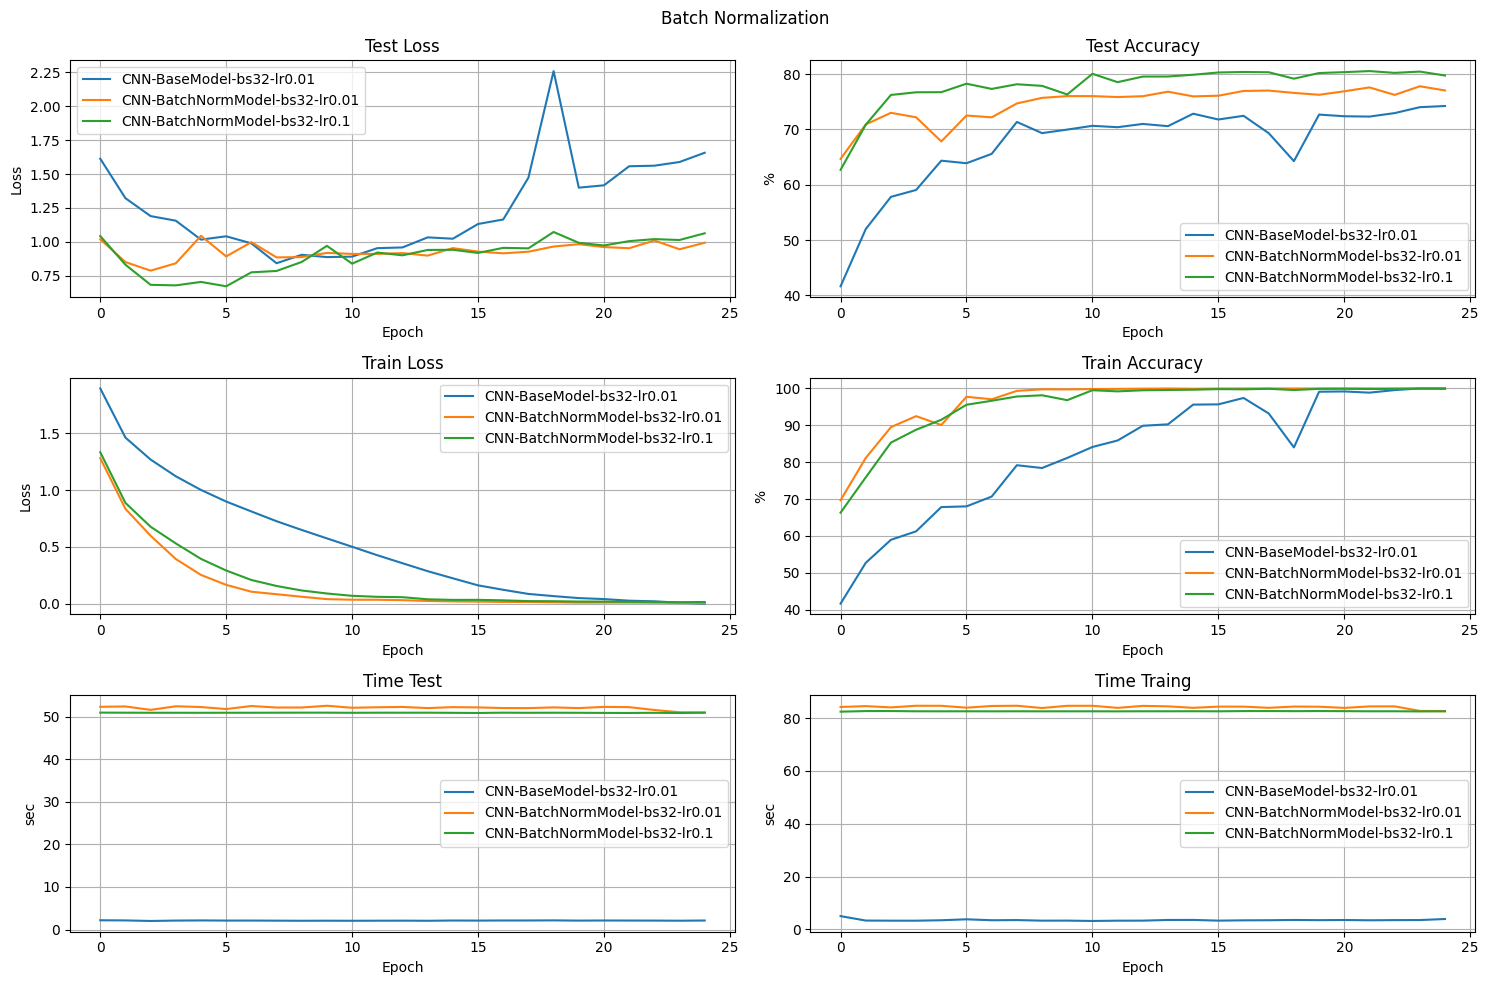

In [83]:
get_run_hist(['zrr3rl9x', 'jqa3mije', '3bntj0rd'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy', 'time_test', 'time_train'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy', 'Time Test', 'Time Traing'], 'Batch Normalization')

###### Beobachtung
- Beide Modelle mit Batch Normalization Performen besser als das Base-Modell
- Der Test-Loss beider Modelle steigt während des Overfittings nicht so stark an
- Beide Modelle overfitten jedoch bereits bei etwa Epoche 3
- Batch Normalisation ist sehr Rechenintensiv

###### Interpretation
Die Batch Normalization ist sehr effektiv. Es ist das beste Modell bisher. Trotzdem braucht es sehr lange zum trainieren, da es deutlich mehr Parameter hat.
Der Test-Loss steigt zwar langsamer an jedoch overfittet das Modell trotzdem sehr früh. Und da die Vorhersagen immer wieder normalisiert werden, ist der Loss automatisch tiefer.


## ADAM Optimizer
Der Adam-Optimizer ist eine Optimierungs-Technik, welche eine individuelle Lernrate für jedes Gewicht berechnet. Dies wird durch die Schätzung der ersten und zweiten Momente des Gradienten erreicht. Der erste Moment ist die durchschnittliche Richtung des bisherigen Gradienten. Der zweite Moment ist die durchschnittliche Gradientenlänge. Dadurch sind die neuen Lernraten abhänig davon, was die bisherigen Gradienten gemacht haben.
Dadurch wird das Training viel stabieler und schneller.
Adam ist gut wenn eine schnelle Konvergenz gewünscht ist.
SGD ist besser wenn das Modell gut generalisieren soll. Ebenfalls benötigt Adam mehr Speicher auf der Grafikkarte, da pro Gewicht zusätzliche Werte gespeichert werden müssen. 

In [84]:
class AdamModel(nn.Module):
    def __init__(self):
        super(AdamModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)  # 30*30*32
        self.conv2 = nn.Conv2d(32, 128, 3)  # 28*28*128
        self.conv3 = nn.Conv2d(128, 256, 3)  # 26*26*256
        self.conv4 = nn.Conv2d(256, 512, 3) # 24*24*512
        self.pool1 = nn.MaxPool2d(2, 2)  # 12*12*512
        self.fc1 = nn.Linear(73728, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

##### Analyse

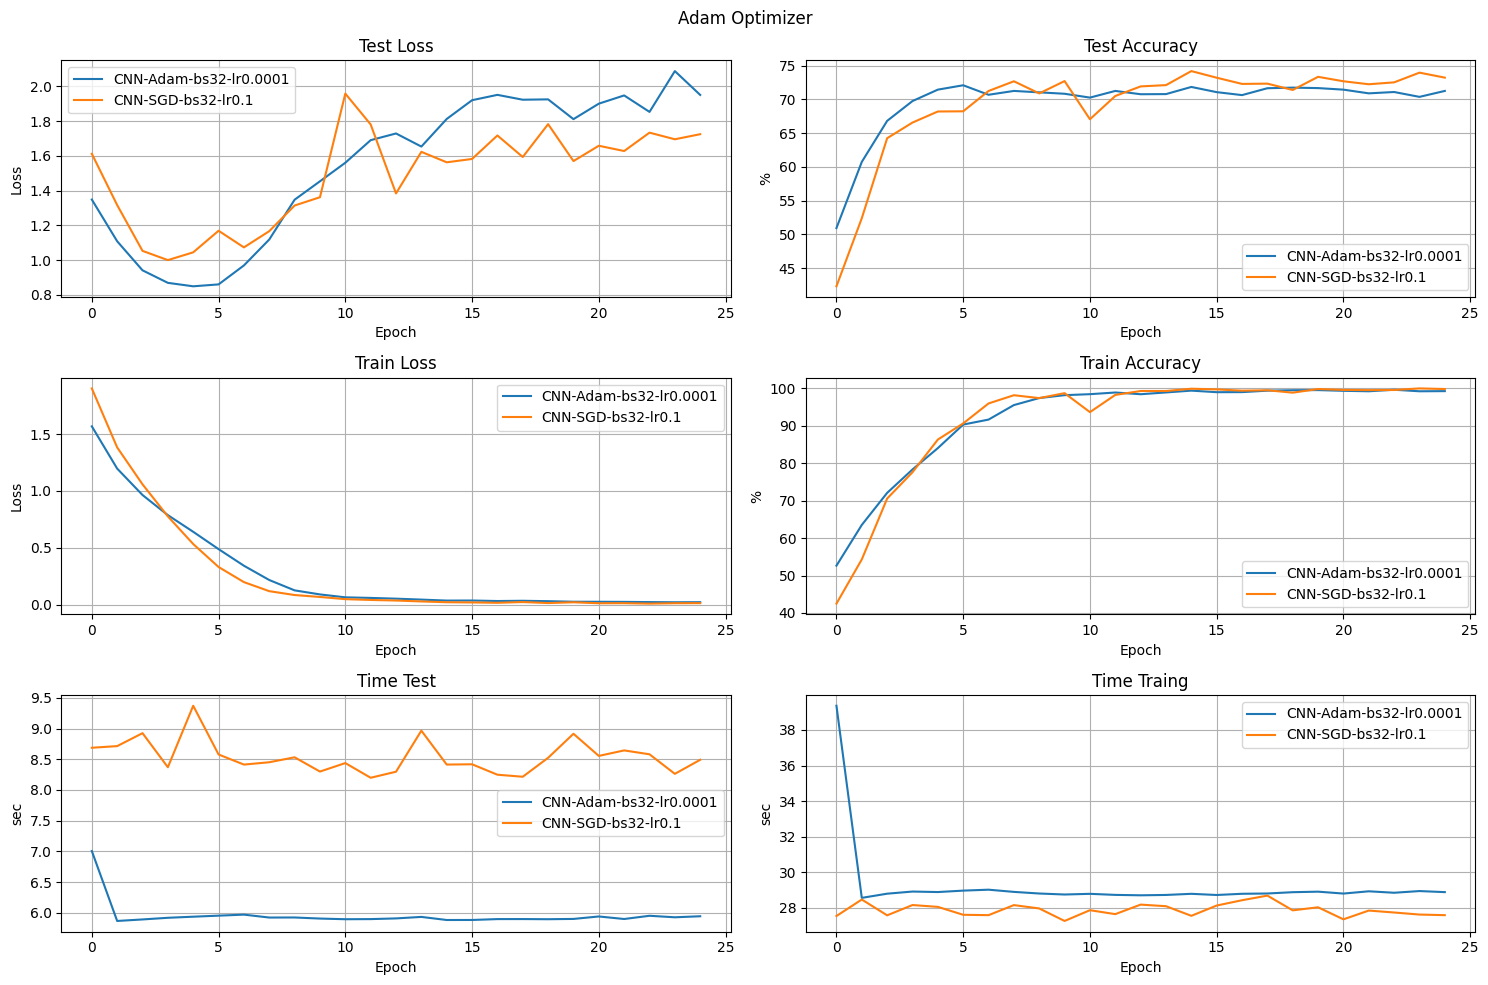

In [85]:
get_run_hist(['f8bt0kbc', 'z2dbm34j'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy', 'time_test', 'time_train'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy', 'Time Test', 'Time Traing'], 'Adam Optimizer')

###### Beobachtung
- Beide Modelle sind von der Leistung her fast identisch
- Das Modell mit Adam-Optimizer scheint zu beginn ein etwas stabileres Training zu haben
- Die Trainingszeiten unterscheiden sich nur im Test-Loop

###### Interpretation
Ich kann mir nicht erklären wieso der Adam-Optimizer nicht besser performt. Es könnte sein, dass ich die perfekten Hyperparameter für Adam noch nicht gefunden habe.


# Transfer Learning
Ich habe mich für ein vortrainiertes ResNet50-Modell entschieden. Zum einen ist es durch die torchvision-library einfach zu integrieren und zum anderen habe ich kein geeignetes Modell gefunden welches auf 32*32 Pixeln trainiert wurde.
 
Für das Transfer Learning sollen alle vortrainierten Gewichte eingefroren werden. Der letzte Fully-Connected Layer muss daraufhin neu instanziert werden.
Dies erreicht man mit dem folgenden Code: 

In [86]:
from torchvision import models

class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        # Freeze model weights
        for param in self.resnet50.parameters():
            param.requires_grad = False
        
        self.resnet50.fc = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.resnet50(x)
        return x
    
models.resnet50(pretrained=True)

C:\FHNW_Programmiersachen\4_Sem\del\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\FHNW_Programmiersachen\4_Sem\del\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Dadruch wird beim Training nur der letzte Fully-Connected Layer trainiert. Die restlichen Gewichte bleiben unverändert. 

Da das ResNet50-Modell auf 224*224 Pixeln trainiert wurde, müssen die Input-Bilder auf diese Grösse skaliert werden(32*32 -> 224*224).
Dazu verwende ich die transforms.Resize-Funktion. Damit kann ich direkt eine Interpolation mitgeben, damit das Bild kein Pixelbrei wird sondern nur sehr verschwommen erscheint.

Files already downloaded and verified


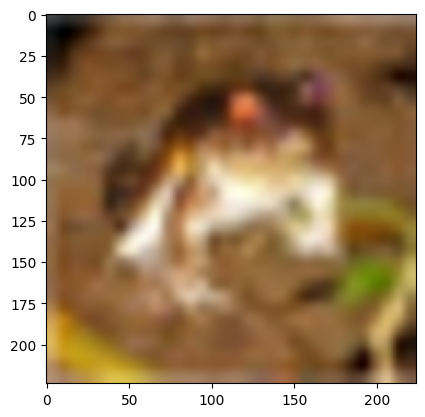

In [87]:
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC, antialias=True), 
    transforms.ToTensor()
    #transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784), inplace=True)
])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

plt.imshow(training_data[0][0].permute(1, 2, 0))
plt.show()

##### Analyse

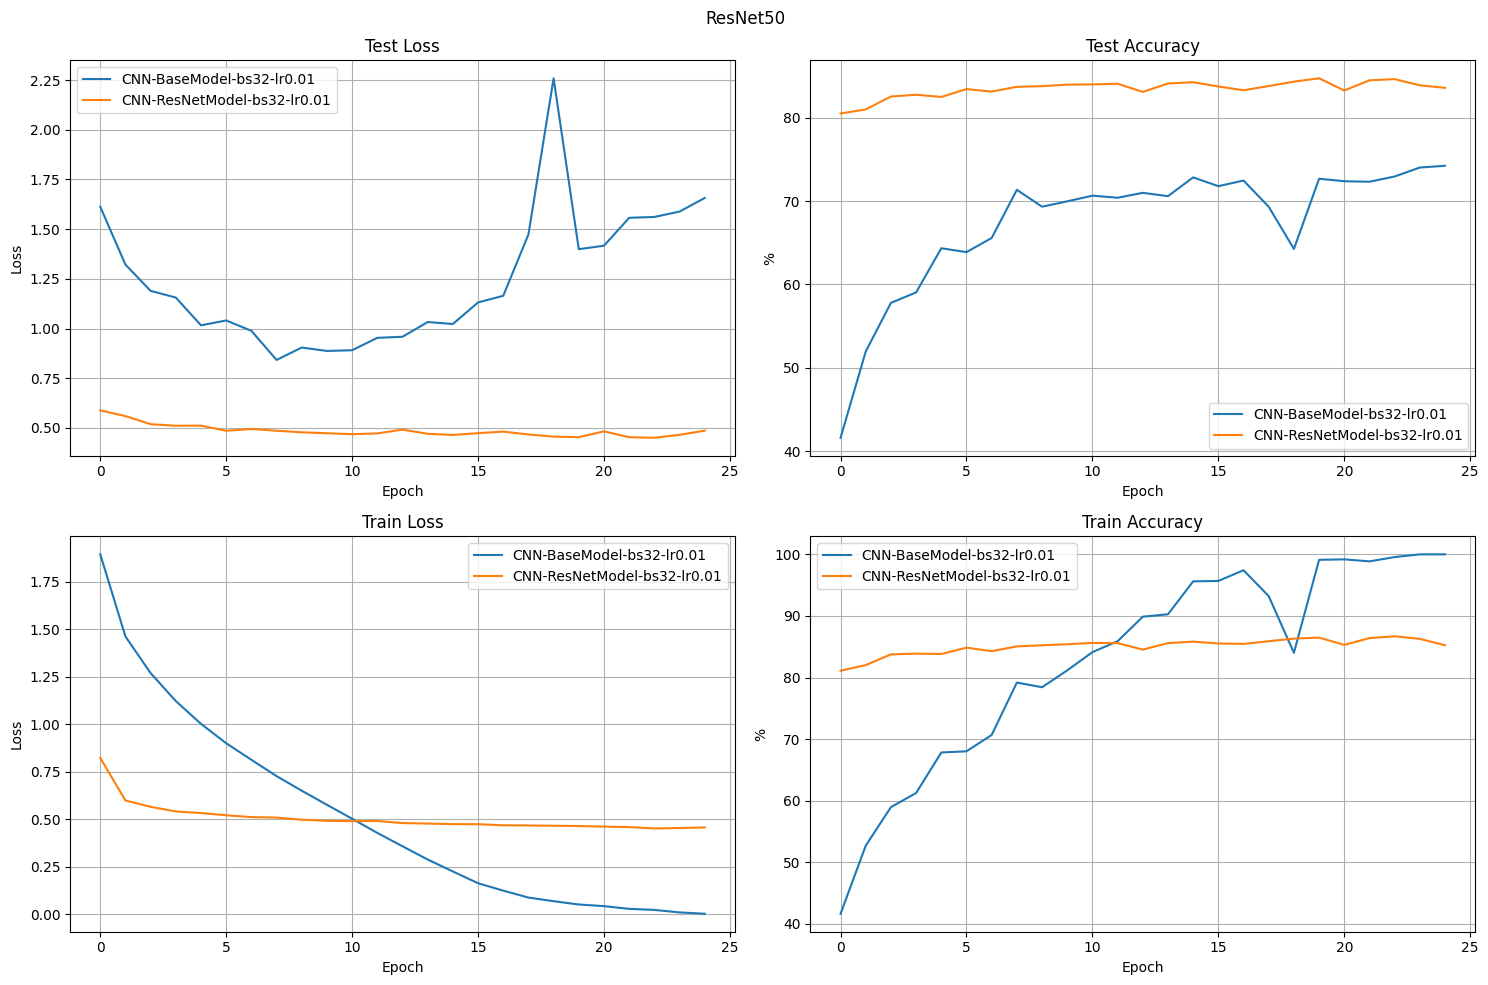

In [88]:
get_run_hist(['zrr3rl9x','44ysi8mo'],
             ['test_loss', 'test_accuracy', 'train_loss', 'train_accuracy'],
             ['Test Loss', 'Test Accuracy', 'Train Loss', 'Train Accuracy'], 'ResNet50')

###### Beobachtung
- Das ResNet50 Modell ist deutlich besser als alle anderen Modelle vorher
- Es erreicht eine Accuracy von 84%
- Das Modell overfittet nicht
- Die Trainings- und Testaccuracy sind sehr nahe beieinander

###### Interpretation
- Durch die vortrainierten Gewichte des ResNet50 Modells konnte eine deutlich bessere Performance erreicht werden
- Das Modell ist sehr gut für den CIFAR10 Datensatz geeignet
- Es ist sehr stabil im Training



# Zusammenfassung
Mir hat die Mini-Challenge sehr viel Spass gemacht. Ich habe sehr viel über CNNs gelernt und konnte viele verschiedene Modelle testen. Ebenfalls war es das erste Mal, dass ich mit Wandb gearbeitet habe. 
Am meisten erstaunt bin ich, wie einfach es ist, ein vortrainiertes Modell zu verwenden. Das ResNet50-Modell hat sehr gut performt und war sehr einfach zu implementieren.
Ebenfalls nehme ich mit, das die Batch-Normalization sehr effektiv ist und das Dropout eine sehr gute Methode ist um Overfitting zu verhindern.

Etwas enttäuscht bin ich von meinen eigenen Architekturen. Ich habe keine gefunden, welche besser performt haben als das Base-Modell. Ich denke, dass ich noch mehr Kombinationen von grösseren Modellen hätte ausprobieren sollen. Dazu fehlte mir aber die Zeit.
Das nächste Mal würde ich von Anfang an auf dem SLURM-Cluster arbeiten. Dies hat einiges vereinfacht. Ebenfalls würde ich mehr Metriken und sonstige Parameter loggen und mich von Anfang an für ein Base-Model eintscheiden und dies dann dabei belassen. 

Für die Erstellung des Codes habe ich teilweise ChatGPT-4o verwendet.  